In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv('train.csv', sep = ',')
X = df.loc[:,'var_0':'var_199']
Y = df.loc[:,'target']
X.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [3]:
fraud_index = np.where(Y==1)
honest_index = np.where(Y==0)
fraud = X.loc[fraud_index]
honest = X.loc[honest_index]

In [4]:
yh = Y.loc[honest_index]
yf = Y.loc[fraud_index]

In [5]:
h_train, h_test, hy_train, hy_test = train_test_split(honest, yh,test_size=0.4,random_state=30)
h_train, h_test, hy_train, hy_test = train_test_split(h_test, hy_test,test_size=0.3,random_state=30)
h_test, h_val, hy_test, hy_val = train_test_split(h_test, hy_test,test_size=0.5,random_state=30)

In [6]:
f_train, f_test, fy_train, fy_test = train_test_split(fraud, yf,test_size=0.3,random_state=30)
f_test, f_val, fy_test, fy_val = train_test_split(f_test, fy_test,test_size=0.5,random_state=30)

In [7]:
len(h_train)/len(f_train)

3.580608473130509

In [8]:
x_train = pd.concat([h_train,f_train],ignore_index = True)
x_test = pd.concat([h_test,f_test],ignore_index = True)
x_val = pd.concat([h_val,f_val],ignore_index = True)

y_train = pd.concat([hy_train,fy_train],ignore_index = True)
y_test = pd.concat([hy_test,fy_test],ignore_index = True)
y_val = pd.concat([hy_val,fy_val],ignore_index = True)

In [9]:
meanx = x_train.mean(axis = 0)
stdx = x_train.std(axis = 0)
x_train_norm = (x_train - meanx)/stdx
x_val_norm = (x_val - meanx)/stdx
x_test_norm = (x_test - meanx)/stdx
x_train_norm=np.asarray(x_train_norm)
x_test_norm=np.asarray(x_test_norm)
x_val_norm=np.asarray(x_val_norm)

In [10]:
import keras
from keras import models
from keras import layers
import tensorflow as tf
from keras.backend import binary_crossentropy
from keras import backend as K
from keras.callbacks import Callback
from keras import optimizers
from keras.backend import mean
from keras import regularizers
from keras.layers import Dropout

Using TensorFlow backend.


In [11]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.clear_session()

In [12]:
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_val = np.asarray(y_val)

In [13]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [14]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [15]:
class new_rna:
    def build_model(self,data_shape,units_list,activation_list):
        self.model = models.Sequential()
        my_init = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=1)
        for i in range(len(units_list)):
            if i == 0:
                self.model.add(layers.Dense(units=units_list[i], activation=activation_list[i], kernel_initializer = my_init,
                                            input_shape=data_shape))
            else:
                self.model.add(layers.Dense(units=units_list[i], activation=activation_list[i]))
        self.model.summary()
           
    def train(self,x_train,y_train,x_val,y_val,batch_size,epochs,loss,metric):
        mom = optimizers.SGD(lr=0.001, decay=0, momentum=0.9, nesterov=True)
        self.model.compile(loss = [loss],metrics = [metric], optimizer = mom)
        history = self.model.fit(x_train,y_train,batch_size = batch_size,epochs = epochs,validation_data = (x_val,y_val))
        self.history_dict = history.history
        self.aux_train = 1
        
    def plot(self):
        if (self.aux_train == 1):
            self.aux_plt = 1
            cost = self.history_dict['loss']
            metric = self.history_dict['f1']
            val_cost = self.history_dict['val_loss']
            val_metric = self.history_dict['val_f1']
            aux_epocas = range(1,len(cost)+1)
            plt.plot(aux_epocas,cost,'b',label = 'Custo - treinamento', color = 'red')
            plt.plot(aux_epocas,val_cost,'b',label = 'Custo - validacao', color = 'blue')
            plt.title(' Valor da Funcao Custo = Treinamento e Validacao')
            plt.xlabel('Épocas')
            plt.ylabel('Custo')
            plt.legend()
            plt.show()
            plt.plot(aux_epocas, metric,'b',label = 'metrica - treinamento',color = 'red')
            plt.plot(aux_epocas, val_metric,'b',label = 'metrica - validacao', color = 'blue')
            plt.title('Valor da métrica – treinamento e validação')
            plt.xlabel('Épocas')
            plt.ylabel('Acertividade')
            plt.legend()
            plt.show()
        else:
            print('Train before plot')

    def predict(self,x_data,y_data):
        if (self.aux_plt == 1):
            class_names = np.array([['Honest'],['Fraud']])
            subtitle = ['Test', 'Val', 'Train']
            for i in range(len(x_data)):
                y_hat = self.model.predict(x_data[i])
                yy_hat = np.round(y_hat)
                yy_hat = yy_hat.astype(int)
                yy_hat = np.ravel(yy_hat)
                f1 = f1_score(y_data[i],yy_hat)
                plot_confusion_matrix(np.int_(y_data[i]), np.int_(yy_hat), classes=class_names,
                                      title='F1_Score = {0}: {1} Data'.format(f1, subtitle[i]))
                plt.show()
            K.clear_session()
        else:
            print('Train before predict')

In [16]:
data_shape = (200,)

loss = 'binary_crossentropy'
metric = f1
batch_size = 32
epochs = 1000

x_data = [x_test_norm,x_val_norm,x_train_norm]
y_data = [y_test,y_val,y_train]

In [17]:
n_list0 = [50,1]
activation_list0 = ['tanh','sigmoid']

In [18]:
rna0 = new_rna()
rna0.build_model(data_shape,n_list0,activation_list0)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 10,101
Trainable params: 10,101
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.cast instead.
Train on 64440 samples, validate on 13810 samples
Epoch 1/1000
64440/64440 [==============================] - 3s 46us/step - loss: 0.3903 - f1: 0.5219 - val_loss: 0.3697 - val_f1: 0.1419
Epoch 2/1000
64440/64440 [==============================] - 2s 30us/step - loss: 0.3626 - f1: 0.5486 - val_loss: 0.3690 - val_f1: 0.1418
Epoch 3/1000
64440/64440 [==============================] - 2s 30us/step - loss: 0.3618 - f1: 0.5521 - val_loss: 0.3684 - val_f1: 0.1414
Epoch 4/1000
64440/64440 [==============================] - 2s 30us/step - loss: 0.3611 - f1: 0.5523 - val_loss: 0.3674 - val_f1: 0.1423
Epoch 5/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.3603 - f1: 0.5522 - val_loss: 0.3676 - val_f1: 0.1438
Epoch 6/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.3598 - f1: 0.5499 - val_loss: 0.3677 - val_f1: 0.1422
Epoch 7/1000
64440/64440 [==============================] - 2s 30us/step - loss:

64440/64440 [==============================] - 2s 30us/step - loss: 0.2689 - f1: 0.6977 - val_loss: 0.4436 - val_f1: 0.1419
Epoch 59/1000
64440/64440 [==============================] - 2s 30us/step - loss: 0.2666 - f1: 0.7022 - val_loss: 0.4487 - val_f1: 0.1435
Epoch 60/1000
64440/64440 [==============================] - 2s 30us/step - loss: 0.2645 - f1: 0.7019 - val_loss: 0.4503 - val_f1: 0.1428
Epoch 61/1000
64440/64440 [==============================] - 2s 30us/step - loss: 0.2626 - f1: 0.7054 - val_loss: 0.4528 - val_f1: 0.1445
Epoch 62/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.2602 - f1: 0.7140 - val_loss: 0.4577 - val_f1: 0.1426
Epoch 63/1000
64440/64440 [==============================] - 2s 30us/step - loss: 0.2588 - f1: 0.7114 - val_loss: 0.4575 - val_f1: 0.1439
Epoch 64/1000
64440/64440 [==============================] - 2s 30us/step - loss: 0.2564 - f1: 0.7183 - val_loss: 0.4647 - val_f1: 0.1446
Epoch 65/1000
64440/64440 [=====================

64440/64440 [==============================] - 2s 30us/step - loss: 0.1718 - f1: 0.8290 - val_loss: 0.6930 - val_f1: 0.1428
Epoch 118/1000
64440/64440 [==============================] - 2s 35us/step - loss: 0.1708 - f1: 0.8283 - val_loss: 0.6953 - val_f1: 0.1451
Epoch 119/1000
64440/64440 [==============================] - 2s 30us/step - loss: 0.1698 - f1: 0.8274 - val_loss: 0.7016 - val_f1: 0.1431
Epoch 120/1000
64440/64440 [==============================] - 2s 30us/step - loss: 0.1686 - f1: 0.8324 - val_loss: 0.7087 - val_f1: 0.1426
Epoch 121/1000
64440/64440 [==============================] - 2s 30us/step - loss: 0.1673 - f1: 0.8348 - val_loss: 0.7122 - val_f1: 0.1462
Epoch 122/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.1667 - f1: 0.8349 - val_loss: 0.7180 - val_f1: 0.1448
Epoch 123/1000
64440/64440 [==============================] - 2s 30us/step - loss: 0.1652 - f1: 0.8328 - val_loss: 0.7258 - val_f1: 0.1443
Epoch 124/1000
64440/64440 [==============

64440/64440 [==============================] - 2s 31us/step - loss: 0.1172 - f1: 0.8933 - val_loss: 1.0062 - val_f1: 0.1428
Epoch 177/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.1167 - f1: 0.8918 - val_loss: 1.0099 - val_f1: 0.1443
Epoch 178/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.1156 - f1: 0.8980 - val_loss: 1.0177 - val_f1: 0.1432
Epoch 179/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.1152 - f1: 0.8951 - val_loss: 1.0236 - val_f1: 0.1433
Epoch 180/1000
64440/64440 [==============================] - 2s 35us/step - loss: 0.1144 - f1: 0.8940 - val_loss: 1.0280 - val_f1: 0.1443
Epoch 181/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.1134 - f1: 0.8974 - val_loss: 1.0298 - val_f1: 0.1438
Epoch 182/1000
64440/64440 [==============================] - 2s 30us/step - loss: 0.1127 - f1: 0.8973 - val_loss: 1.0399 - val_f1: 0.1446
Epoch 183/1000
64440/64440 [==============

64440/64440 [==============================] - 2s 32us/step - loss: 0.0813 - f1: 0.9382 - val_loss: 1.3037 - val_f1: 0.1440
Epoch 236/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0811 - f1: 0.9342 - val_loss: 1.3066 - val_f1: 0.1427
Epoch 237/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0807 - f1: 0.9367 - val_loss: 1.3109 - val_f1: 0.1441
Epoch 238/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0803 - f1: 0.9359 - val_loss: 1.3166 - val_f1: 0.1427
Epoch 239/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0797 - f1: 0.9359 - val_loss: 1.3181 - val_f1: 0.1432
Epoch 240/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0791 - f1: 0.9381 - val_loss: 1.3244 - val_f1: 0.1444
Epoch 241/1000
64440/64440 [==============================] - 2s 30us/step - loss: 0.0785 - f1: 0.9374 - val_loss: 1.3274 - val_f1: 0.1432
Epoch 242/1000
64440/64440 [==============

Epoch 294/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0571 - f1: 0.9652 - val_loss: 1.5536 - val_f1: 0.1437
Epoch 295/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0569 - f1: 0.9642 - val_loss: 1.5570 - val_f1: 0.1421
Epoch 296/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0566 - f1: 0.9643 - val_loss: 1.5613 - val_f1: 0.1434
Epoch 297/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0561 - f1: 0.9633 - val_loss: 1.5678 - val_f1: 0.1433
Epoch 298/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0556 - f1: 0.9660 - val_loss: 1.5671 - val_f1: 0.1438
Epoch 299/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0557 - f1: 0.9657 - val_loss: 1.5719 - val_f1: 0.1431
Epoch 300/1000
64440/64440 [==============================] - 2s 30us/step - loss: 0.0551 - f1: 0.9661 - val_loss: 1.5770 - val_f1: 0.1440
Epoch 301/1000
64440/64440 

Epoch 353/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0401 - f1: 0.9832 - val_loss: 1.7536 - val_f1: 0.1424
Epoch 354/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0400 - f1: 0.9841 - val_loss: 1.7542 - val_f1: 0.1426
Epoch 355/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0397 - f1: 0.9844 - val_loss: 1.7552 - val_f1: 0.1426
Epoch 356/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0396 - f1: 0.9838 - val_loss: 1.7602 - val_f1: 0.1430
Epoch 357/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0393 - f1: 0.9842 - val_loss: 1.7637 - val_f1: 0.1424
Epoch 358/1000
64440/64440 [==============================] - 2s 35us/step - loss: 0.0390 - f1: 0.9849 - val_loss: 1.7661 - val_f1: 0.1427
Epoch 359/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0388 - f1: 0.9859 - val_loss: 1.7673 - val_f1: 0.1420
Epoch 360/1000
64440/64440 

Epoch 412/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0286 - f1: 0.9953 - val_loss: 1.9062 - val_f1: 0.1421
Epoch 413/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0285 - f1: 0.9936 - val_loss: 1.9054 - val_f1: 0.1424
Epoch 414/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0283 - f1: 0.9939 - val_loss: 1.9099 - val_f1: 0.1421
Epoch 415/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0283 - f1: 0.9946 - val_loss: 1.9134 - val_f1: 0.1419
Epoch 416/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0281 - f1: 0.9944 - val_loss: 1.9144 - val_f1: 0.1429
Epoch 417/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0280 - f1: 0.9945 - val_loss: 1.9184 - val_f1: 0.1435
Epoch 418/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0277 - f1: 0.9953 - val_loss: 1.9185 - val_f1: 0.1424
Epoch 419/1000
64440/64440 

Epoch 471/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0212 - f1: 0.9980 - val_loss: 2.0247 - val_f1: 0.1429
Epoch 472/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0211 - f1: 0.9968 - val_loss: 2.0228 - val_f1: 0.1427
Epoch 473/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0211 - f1: 0.9980 - val_loss: 2.0260 - val_f1: 0.1429
Epoch 474/1000
64440/64440 [==============================] - 2s 35us/step - loss: 0.0209 - f1: 0.9981 - val_loss: 2.0268 - val_f1: 0.1428
Epoch 475/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0208 - f1: 0.9981 - val_loss: 2.0313 - val_f1: 0.1428
Epoch 476/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0207 - f1: 0.9973 - val_loss: 2.0313 - val_f1: 0.1434
Epoch 477/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0207 - f1: 0.9973 - val_loss: 2.0308 - val_f1: 0.1423
Epoch 478/1000
64440/64440 

Epoch 530/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0163 - f1: 0.9993 - val_loss: 2.1091 - val_f1: 0.1434
Epoch 531/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0163 - f1: 0.9989 - val_loss: 2.1109 - val_f1: 0.1432
Epoch 532/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0161 - f1: 0.9984 - val_loss: 2.1097 - val_f1: 0.1428
Epoch 533/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0162 - f1: 0.9984 - val_loss: 2.1120 - val_f1: 0.1434
Epoch 534/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0161 - f1: 0.9989 - val_loss: 2.1136 - val_f1: 0.1431
Epoch 535/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0160 - f1: 0.9989 - val_loss: 2.1148 - val_f1: 0.1432
Epoch 536/1000
64440/64440 [==============================] - 2s 35us/step - loss: 0.0160 - f1: 0.9993 - val_loss: 2.1170 - val_f1: 0.1433
Epoch 537/1000
64440/64440 

Epoch 589/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0131 - f1: 0.9997 - val_loss: 2.1763 - val_f1: 0.1429
Epoch 590/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0130 - f1: 0.9989 - val_loss: 2.1773 - val_f1: 0.1430
Epoch 591/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0130 - f1: 0.9993 - val_loss: 2.1780 - val_f1: 0.1428
Epoch 592/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0129 - f1: 0.9988 - val_loss: 2.1792 - val_f1: 0.1426
Epoch 593/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0129 - f1: 0.9992 - val_loss: 2.1798 - val_f1: 0.1431
Epoch 594/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0128 - f1: 0.9992 - val_loss: 2.1804 - val_f1: 0.1429
Epoch 595/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0128 - f1: 0.9993 - val_loss: 2.1813 - val_f1: 0.1427
Epoch 596/1000
64440/64440 

Epoch 648/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0107 - f1: 0.9994 - val_loss: 2.2291 - val_f1: 0.1430
Epoch 649/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0107 - f1: 0.9993 - val_loss: 2.2300 - val_f1: 0.1432
Epoch 650/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0106 - f1: 0.9995 - val_loss: 2.2302 - val_f1: 0.1432
Epoch 651/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0106 - f1: 0.9999 - val_loss: 2.2318 - val_f1: 0.1431
Epoch 652/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0106 - f1: 0.9999 - val_loss: 2.2329 - val_f1: 0.1430
Epoch 653/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0106 - f1: 0.9999 - val_loss: 2.2333 - val_f1: 0.1435
Epoch 654/1000
64440/64440 [==============================] - 2s 37us/step - loss: 0.0105 - f1: 0.9994 - val_loss: 2.2347 - val_f1: 0.1433
Epoch 655/1000
64440/64440 

Epoch 707/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0091 - f1: 1.0000 - val_loss: 2.2729 - val_f1: 0.1428
Epoch 708/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0090 - f1: 1.0000 - val_loss: 2.2737 - val_f1: 0.1430
Epoch 709/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0090 - f1: 0.9989 - val_loss: 2.2751 - val_f1: 0.1430
Epoch 710/1000
64440/64440 [==============================] - 2s 34us/step - loss: 0.0090 - f1: 1.0000 - val_loss: 2.2746 - val_f1: 0.1430
Epoch 711/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0090 - f1: 1.0000 - val_loss: 2.2749 - val_f1: 0.1431
Epoch 712/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0089 - f1: 0.9995 - val_loss: 2.2766 - val_f1: 0.1430
Epoch 713/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0089 - f1: 1.0000 - val_loss: 2.2761 - val_f1: 0.1431
Epoch 714/1000
64440/64440 

Epoch 766/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0078 - f1: 1.0000 - val_loss: 2.3107 - val_f1: 0.1428
Epoch 767/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0078 - f1: 0.9995 - val_loss: 2.3120 - val_f1: 0.1430
Epoch 768/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0078 - f1: 1.0000 - val_loss: 2.3106 - val_f1: 0.1428
Epoch 769/1000
64440/64440 [==============================] - 2s 34us/step - loss: 0.0077 - f1: 0.9990 - val_loss: 2.3126 - val_f1: 0.1429
Epoch 770/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0077 - f1: 0.9995 - val_loss: 2.3125 - val_f1: 0.1430
Epoch 771/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0077 - f1: 1.0000 - val_loss: 2.3126 - val_f1: 0.1428
Epoch 772/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0077 - f1: 0.9995 - val_loss: 2.3147 - val_f1: 0.1426
Epoch 773/1000
64440/64440 

Epoch 825/1000
64440/64440 [==============================] - 2s 30us/step - loss: 0.0068 - f1: 0.9995 - val_loss: 2.3422 - val_f1: 0.1427
Epoch 826/1000
64440/64440 [==============================] - 2s 30us/step - loss: 0.0068 - f1: 1.0000 - val_loss: 2.3436 - val_f1: 0.1427
Epoch 827/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0068 - f1: 1.0000 - val_loss: 2.3435 - val_f1: 0.1428
Epoch 828/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0068 - f1: 0.9995 - val_loss: 2.3438 - val_f1: 0.1425
Epoch 829/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0068 - f1: 1.0000 - val_loss: 2.3444 - val_f1: 0.1426
Epoch 830/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0067 - f1: 1.0000 - val_loss: 2.3455 - val_f1: 0.1427
Epoch 831/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0067 - f1: 0.9999 - val_loss: 2.3464 - val_f1: 0.1425
Epoch 832/1000
64440/64440 

64440/64440 [==============================] - 2s 31us/step - loss: 0.0061 - f1: 1.0000 - val_loss: 2.3689 - val_f1: 0.1426
Epoch 884/1000
64440/64440 [==============================] - 2s 30us/step - loss: 0.0060 - f1: 1.0000 - val_loss: 2.3697 - val_f1: 0.1429
Epoch 885/1000
64440/64440 [==============================] - 2s 30us/step - loss: 0.0060 - f1: 0.9985 - val_loss: 2.3709 - val_f1: 0.1428
Epoch 886/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0060 - f1: 0.9995 - val_loss: 2.3716 - val_f1: 0.1428
Epoch 887/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0060 - f1: 0.9999 - val_loss: 2.3718 - val_f1: 0.1427
Epoch 888/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0060 - f1: 0.9995 - val_loss: 2.3722 - val_f1: 0.1428
Epoch 889/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0060 - f1: 0.9995 - val_loss: 2.3731 - val_f1: 0.1428
Epoch 890/1000
64440/64440 [==============

64440/64440 [==============================] - 2s 30us/step - loss: 0.0054 - f1: 0.9990 - val_loss: 2.3946 - val_f1: 0.1431
Epoch 943/1000
64440/64440 [==============================] - 2s 30us/step - loss: 0.0054 - f1: 0.9990 - val_loss: 2.3938 - val_f1: 0.1430
Epoch 944/1000
64440/64440 [==============================] - 2s 30us/step - loss: 0.0054 - f1: 0.9999 - val_loss: 2.3947 - val_f1: 0.1429
Epoch 945/1000
64440/64440 [==============================] - 2s 30us/step - loss: 0.0054 - f1: 1.0000 - val_loss: 2.3946 - val_f1: 0.1431
Epoch 946/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0054 - f1: 0.9995 - val_loss: 2.3950 - val_f1: 0.1428
Epoch 947/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0054 - f1: 1.0000 - val_loss: 2.3961 - val_f1: 0.1429
Epoch 948/1000
64440/64440 [==============================] - 2s 29us/step - loss: 0.0054 - f1: 0.9995 - val_loss: 2.3962 - val_f1: 0.1427
Epoch 949/1000
64440/64440 [==============

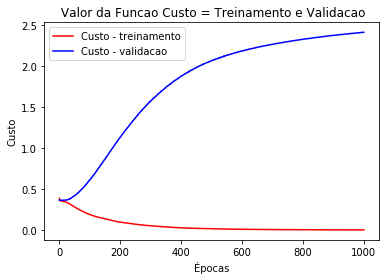

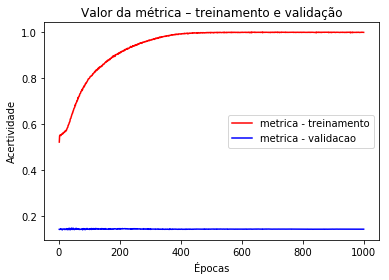

In [19]:
rna0.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna0.plot()

Confusion matrix, without normalization
[[9153 1641]
 [1544 1471]]


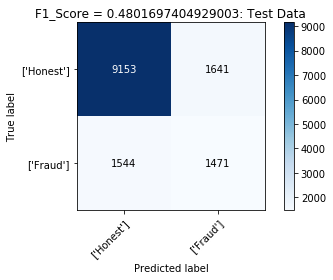

Confusion matrix, without normalization
[[9086 1709]
 [1543 1472]]


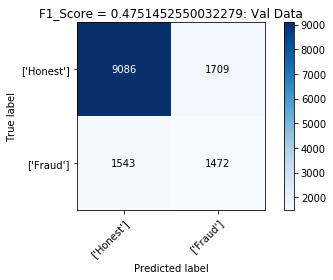

Confusion matrix, without normalization
[[50372     0]
 [    1 14067]]


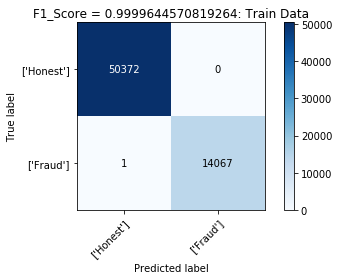

In [20]:
rna0.predict(x_data,y_data)

In [21]:
n_list1 = [100,1]
activation_list1 = ['tanh','sigmoid']

In [22]:
rna1 = new_rna()
rna1.build_model(data_shape,n_list1,activation_list1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 20,201
Trainable params: 20,201
Non-trainable params: 0
_________________________________________________________________


Train on 64440 samples, validate on 13810 samples
Epoch 1/1000
64440/64440 [==============================] - 2s 38us/step - loss: 0.3882 - f1: 0.5209 - val_loss: 0.3685 - val_f1: 0.1397
Epoch 2/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.3628 - f1: 0.5532 - val_loss: 0.3689 - val_f1: 0.1405
Epoch 3/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.3619 - f1: 0.5436 - val_loss: 0.3681 - val_f1: 0.1436
Epoch 4/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.3614 - f1: 0.5497 - val_loss: 0.3684 - val_f1: 0.1403
Epoch 5/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.3605 - f1: 0.5488 - val_loss: 0.3689 - val_f1: 0.1441
Epoch 6/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.3599 - f1: 0.5513 - val_loss: 0.3673 - val_f1: 0.1441
Epoch 7/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.3592 - f1: 0.5540 - val_loss: 0.3677 - val_f1

64440/64440 [==============================] - 2s 31us/step - loss: 0.2026 - f1: 0.7914 - val_loss: 0.5076 - val_f1: 0.1426
Epoch 61/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.1985 - f1: 0.7979 - val_loss: 0.5104 - val_f1: 0.1421
Epoch 62/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.1945 - f1: 0.7998 - val_loss: 0.5178 - val_f1: 0.1430
Epoch 63/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.1904 - f1: 0.8081 - val_loss: 0.5213 - val_f1: 0.1388
Epoch 64/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.1864 - f1: 0.8108 - val_loss: 0.5340 - val_f1: 0.1412
Epoch 65/1000
64440/64440 [==============================] - 2s 35us/step - loss: 0.1820 - f1: 0.8168 - val_loss: 0.5420 - val_f1: 0.1412
Epoch 66/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.1781 - f1: 0.8215 - val_loss: 0.5438 - val_f1: 0.1414
Epoch 67/1000
64440/64440 [=====================

64440/64440 [==============================] - 2s 34us/step - loss: 0.0425 - f1: 0.9915 - val_loss: 0.9712 - val_f1: 0.1407
Epoch 120/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0416 - f1: 0.9922 - val_loss: 0.9781 - val_f1: 0.1423
Epoch 121/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0405 - f1: 0.9924 - val_loss: 0.9855 - val_f1: 0.1418
Epoch 122/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0393 - f1: 0.9931 - val_loss: 0.9922 - val_f1: 0.1435
Epoch 123/1000
64440/64440 [==============================] - 2s 34us/step - loss: 0.0382 - f1: 0.9947 - val_loss: 1.0012 - val_f1: 0.1419
Epoch 124/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0374 - f1: 0.9952 - val_loss: 1.0031 - val_f1: 0.1427
Epoch 125/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0363 - f1: 0.9962 - val_loss: 1.0080 - val_f1: 0.1417
Epoch 126/1000
64440/64440 [==============

64440/64440 [==============================] - 2s 36us/step - loss: 0.0130 - f1: 1.0000 - val_loss: 1.2439 - val_f1: 0.1422
Epoch 179/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0128 - f1: 0.9980 - val_loss: 1.2482 - val_f1: 0.1427
Epoch 180/1000
64440/64440 [==============================] - 2s 34us/step - loss: 0.0127 - f1: 0.9995 - val_loss: 1.2485 - val_f1: 0.1419
Epoch 181/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0125 - f1: 0.9990 - val_loss: 1.2528 - val_f1: 0.1418
Epoch 182/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0123 - f1: 0.9995 - val_loss: 1.2568 - val_f1: 0.1423
Epoch 183/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0121 - f1: 0.9995 - val_loss: 1.2591 - val_f1: 0.1420
Epoch 184/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0120 - f1: 1.0000 - val_loss: 1.2611 - val_f1: 0.1419
Epoch 185/1000
64440/64440 [==============

64440/64440 [==============================] - 2s 35us/step - loss: 0.0068 - f1: 0.9990 - val_loss: 1.3769 - val_f1: 0.1427
Epoch 238/1000
64440/64440 [==============================] - 2s 36us/step - loss: 0.0068 - f1: 0.9985 - val_loss: 1.3782 - val_f1: 0.1418
Epoch 239/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0067 - f1: 1.0000 - val_loss: 1.3791 - val_f1: 0.1422
Epoch 240/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0066 - f1: 1.0000 - val_loss: 1.3818 - val_f1: 0.1422
Epoch 241/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0066 - f1: 0.9995 - val_loss: 1.3828 - val_f1: 0.1418
Epoch 242/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0065 - f1: 1.0000 - val_loss: 1.3848 - val_f1: 0.1423
Epoch 243/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0065 - f1: 0.9995 - val_loss: 1.3859 - val_f1: 0.1422
Epoch 244/1000
64440/64440 [==============

64440/64440 [==============================] - 2s 32us/step - loss: 0.0045 - f1: 0.9990 - val_loss: 1.4575 - val_f1: 0.1422
Epoch 297/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0044 - f1: 0.9995 - val_loss: 1.4599 - val_f1: 0.1423
Epoch 298/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0044 - f1: 1.0000 - val_loss: 1.4606 - val_f1: 0.1423
Epoch 299/1000
64440/64440 [==============================] - 2s 36us/step - loss: 0.0044 - f1: 1.0000 - val_loss: 1.4621 - val_f1: 0.1426
Epoch 300/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0043 - f1: 1.0000 - val_loss: 1.4621 - val_f1: 0.1425
Epoch 301/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0043 - f1: 0.9995 - val_loss: 1.4644 - val_f1: 0.1421
Epoch 302/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0043 - f1: 1.0000 - val_loss: 1.4653 - val_f1: 0.1423
Epoch 303/1000
64440/64440 [==============

64440/64440 [==============================] - 2s 32us/step - loss: 0.0033 - f1: 1.0000 - val_loss: 1.5162 - val_f1: 0.1428
Epoch 356/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0032 - f1: 0.9995 - val_loss: 1.5170 - val_f1: 0.1427
Epoch 357/1000
64440/64440 [==============================] - 2s 34us/step - loss: 0.0032 - f1: 0.9990 - val_loss: 1.5173 - val_f1: 0.1427
Epoch 358/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0032 - f1: 1.0000 - val_loss: 1.5184 - val_f1: 0.1425
Epoch 359/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0032 - f1: 1.0000 - val_loss: 1.5195 - val_f1: 0.1425
Epoch 360/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0032 - f1: 0.9985 - val_loss: 1.5205 - val_f1: 0.1425
Epoch 361/1000
64440/64440 [==============================] - 2s 36us/step - loss: 0.0032 - f1: 0.9995 - val_loss: 1.5213 - val_f1: 0.1423
Epoch 362/1000
64440/64440 [==============

64440/64440 [==============================] - 2s 32us/step - loss: 0.0025 - f1: 0.9990 - val_loss: 1.5603 - val_f1: 0.1429
Epoch 415/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0025 - f1: 1.0000 - val_loss: 1.5610 - val_f1: 0.1427
Epoch 416/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0025 - f1: 1.0000 - val_loss: 1.5609 - val_f1: 0.1427
Epoch 417/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0025 - f1: 1.0000 - val_loss: 1.5625 - val_f1: 0.1428
Epoch 418/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0025 - f1: 1.0000 - val_loss: 1.5627 - val_f1: 0.1429
Epoch 419/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.0025 - f1: 0.9990 - val_loss: 1.5635 - val_f1: 0.1427
Epoch 420/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0025 - f1: 0.9995 - val_loss: 1.5642 - val_f1: 0.1428
Epoch 421/1000
64440/64440 [==============

64440/64440 [==============================] - 2s 35us/step - loss: 0.0021 - f1: 1.0000 - val_loss: 1.5946 - val_f1: 0.1428
Epoch 474/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0021 - f1: 0.9990 - val_loss: 1.5956 - val_f1: 0.1427
Epoch 475/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0021 - f1: 1.0000 - val_loss: 1.5963 - val_f1: 0.1427
Epoch 476/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0021 - f1: 0.9990 - val_loss: 1.5964 - val_f1: 0.1424
Epoch 477/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0020 - f1: 0.9995 - val_loss: 1.5978 - val_f1: 0.1428
Epoch 478/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0020 - f1: 1.0000 - val_loss: 1.5980 - val_f1: 0.1427
Epoch 479/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0020 - f1: 1.0000 - val_loss: 1.5985 - val_f1: 0.1425
Epoch 480/1000
64440/64440 [==============

64440/64440 [==============================] - 2s 32us/step - loss: 0.0017 - f1: 1.0000 - val_loss: 1.6240 - val_f1: 0.1424
Epoch 533/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0017 - f1: 0.9995 - val_loss: 1.6245 - val_f1: 0.1423
Epoch 534/1000
64440/64440 [==============================] - 2s 36us/step - loss: 0.0017 - f1: 0.9995 - val_loss: 1.6245 - val_f1: 0.1424
Epoch 535/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0017 - f1: 1.0000 - val_loss: 1.6251 - val_f1: 0.1423
Epoch 536/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0017 - f1: 0.9995 - val_loss: 1.6255 - val_f1: 0.1424
Epoch 537/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0017 - f1: 0.9990 - val_loss: 1.6260 - val_f1: 0.1424
Epoch 538/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0017 - f1: 0.9995 - val_loss: 1.6264 - val_f1: 0.1424
Epoch 539/1000
64440/64440 [==============

64440/64440 [==============================] - 2s 32us/step - loss: 0.0015 - f1: 0.9990 - val_loss: 1.6481 - val_f1: 0.1423
Epoch 592/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0015 - f1: 0.9995 - val_loss: 1.6486 - val_f1: 0.1423
Epoch 593/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0015 - f1: 0.9985 - val_loss: 1.6490 - val_f1: 0.1423
Epoch 594/1000
64440/64440 [==============================] - 2s 36us/step - loss: 0.0015 - f1: 0.9995 - val_loss: 1.6492 - val_f1: 0.1424
Epoch 595/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0015 - f1: 0.9990 - val_loss: 1.6498 - val_f1: 0.1422
Epoch 596/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0015 - f1: 0.9995 - val_loss: 1.6496 - val_f1: 0.1423
Epoch 597/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0015 - f1: 0.9995 - val_loss: 1.6506 - val_f1: 0.1422
Epoch 598/1000
64440/64440 [==============

64440/64440 [==============================] - 2s 32us/step - loss: 0.0013 - f1: 0.9995 - val_loss: 1.6694 - val_f1: 0.1422
Epoch 651/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0013 - f1: 1.0000 - val_loss: 1.6697 - val_f1: 0.1424
Epoch 652/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0013 - f1: 0.9995 - val_loss: 1.6699 - val_f1: 0.1422
Epoch 653/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0013 - f1: 0.9990 - val_loss: 1.6703 - val_f1: 0.1424
Epoch 654/1000
64440/64440 [==============================] - 2s 36us/step - loss: 0.0013 - f1: 0.9990 - val_loss: 1.6702 - val_f1: 0.1424
Epoch 655/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0013 - f1: 1.0000 - val_loss: 1.6710 - val_f1: 0.1422
Epoch 656/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0013 - f1: 0.9995 - val_loss: 1.6710 - val_f1: 0.1423
Epoch 657/1000
64440/64440 [==============

64440/64440 [==============================] - 2s 32us/step - loss: 0.0012 - f1: 0.9990 - val_loss: 1.6878 - val_f1: 0.1424
Epoch 710/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0012 - f1: 0.9990 - val_loss: 1.6879 - val_f1: 0.1423
Epoch 711/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0012 - f1: 0.9995 - val_loss: 1.6882 - val_f1: 0.1425
Epoch 712/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0012 - f1: 1.0000 - val_loss: 1.6885 - val_f1: 0.1424
Epoch 713/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0012 - f1: 0.9990 - val_loss: 1.6886 - val_f1: 0.1423
Epoch 714/1000
64440/64440 [==============================] - 2s 36us/step - loss: 0.0012 - f1: 0.9990 - val_loss: 1.6887 - val_f1: 0.1424
Epoch 715/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0011 - f1: 0.9990 - val_loss: 1.6895 - val_f1: 0.1424
Epoch 716/1000
64440/64440 [==============

64440/64440 [==============================] - 2s 32us/step - loss: 0.0010 - f1: 1.0000 - val_loss: 1.7035 - val_f1: 0.1421
Epoch 769/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0010 - f1: 0.9995 - val_loss: 1.7037 - val_f1: 0.1422
Epoch 770/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0010 - f1: 0.9995 - val_loss: 1.7040 - val_f1: 0.1423
Epoch 771/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0010 - f1: 1.0000 - val_loss: 1.7038 - val_f1: 0.1424
Epoch 772/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0010 - f1: 1.0000 - val_loss: 1.7041 - val_f1: 0.1423
Epoch 773/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0010 - f1: 1.0000 - val_loss: 1.7046 - val_f1: 0.1424
Epoch 774/1000
64440/64440 [==============================] - 2s 36us/step - loss: 0.0010 - f1: 0.9995 - val_loss: 1.7053 - val_f1: 0.1422
Epoch 775/1000
64440/64440 [==============

64440/64440 [==============================] - 2s 36us/step - loss: 9.4770e-04 - f1: 1.0000 - val_loss: 1.7180 - val_f1: 0.1420
Epoch 827/1000
64440/64440 [==============================] - 2s 32us/step - loss: 9.4638e-04 - f1: 1.0000 - val_loss: 1.7181 - val_f1: 0.1420
Epoch 828/1000
64440/64440 [==============================] - 2s 35us/step - loss: 9.4478e-04 - f1: 0.9995 - val_loss: 1.7183 - val_f1: 0.1418
Epoch 829/1000
64440/64440 [==============================] - 2s 32us/step - loss: 9.4320e-04 - f1: 0.9990 - val_loss: 1.7183 - val_f1: 0.1420
Epoch 830/1000
64440/64440 [==============================] - 2s 32us/step - loss: 9.4169e-04 - f1: 1.0000 - val_loss: 1.7190 - val_f1: 0.1420
Epoch 831/1000
64440/64440 [==============================] - 2s 33us/step - loss: 9.4029e-04 - f1: 0.9995 - val_loss: 1.7193 - val_f1: 0.1420
Epoch 832/1000
64440/64440 [==============================] - 2s 32us/step - loss: 9.3879e-04 - f1: 1.0000 - val_loss: 1.7195 - val_f1: 0.1420
Epoch 833/1000

64440/64440 [==============================] - 2s 33us/step - loss: 8.6821e-04 - f1: 1.0000 - val_loss: 1.7307 - val_f1: 0.1418
Epoch 884/1000
64440/64440 [==============================] - 2s 32us/step - loss: 8.6691e-04 - f1: 0.9990 - val_loss: 1.7309 - val_f1: 0.1419
Epoch 885/1000
64440/64440 [==============================] - 2s 36us/step - loss: 8.6562e-04 - f1: 0.9990 - val_loss: 1.7308 - val_f1: 0.1420
Epoch 886/1000
64440/64440 [==============================] - 2s 32us/step - loss: 8.6442e-04 - f1: 0.9990 - val_loss: 1.7308 - val_f1: 0.1420
Epoch 887/1000
64440/64440 [==============================] - 2s 32us/step - loss: 8.6319e-04 - f1: 1.0000 - val_loss: 1.7314 - val_f1: 0.1420
Epoch 888/1000
64440/64440 [==============================] - 2s 32us/step - loss: 8.6189e-04 - f1: 1.0000 - val_loss: 1.7315 - val_f1: 0.1420
Epoch 889/1000
64440/64440 [==============================] - 2s 32us/step - loss: 8.6056e-04 - f1: 0.9995 - val_loss: 1.7316 - val_f1: 0.1419
Epoch 890/1000

64440/64440 [==============================] - 2s 32us/step - loss: 8.0044e-04 - f1: 1.0000 - val_loss: 1.7422 - val_f1: 0.1421
Epoch 941/1000
64440/64440 [==============================] - 2s 32us/step - loss: 7.9923e-04 - f1: 0.9995 - val_loss: 1.7427 - val_f1: 0.1422
Epoch 942/1000
64440/64440 [==============================] - 2s 32us/step - loss: 7.9822e-04 - f1: 0.9995 - val_loss: 1.7427 - val_f1: 0.1423
Epoch 943/1000
64440/64440 [==============================] - 2s 32us/step - loss: 7.9706e-04 - f1: 0.9995 - val_loss: 1.7429 - val_f1: 0.1422
Epoch 944/1000
64440/64440 [==============================] - 2s 33us/step - loss: 7.9604e-04 - f1: 0.9995 - val_loss: 1.7430 - val_f1: 0.1421
Epoch 945/1000
64440/64440 [==============================] - 2s 35us/step - loss: 7.9494e-04 - f1: 1.0000 - val_loss: 1.7432 - val_f1: 0.1421
Epoch 946/1000
64440/64440 [==============================] - 2s 32us/step - loss: 7.9385e-04 - f1: 1.0000 - val_loss: 1.7435 - val_f1: 0.1421
Epoch 947/1000

64440/64440 [==============================] - 2s 35us/step - loss: 7.4195e-04 - f1: 1.0000 - val_loss: 1.7525 - val_f1: 0.1423
Epoch 998/1000
64440/64440 [==============================] - 2s 32us/step - loss: 7.4103e-04 - f1: 1.0000 - val_loss: 1.7526 - val_f1: 0.1424
Epoch 999/1000
64440/64440 [==============================] - 2s 32us/step - loss: 7.4000e-04 - f1: 0.9995 - val_loss: 1.7528 - val_f1: 0.1426
Epoch 1000/1000
64440/64440 [==============================] - 2s 32us/step - loss: 7.3911e-04 - f1: 0.9995 - val_loss: 1.7532 - val_f1: 0.1424


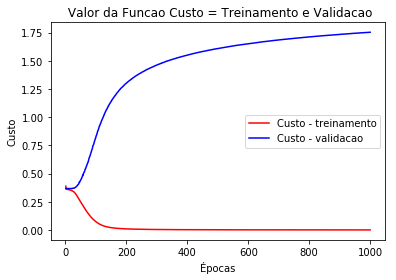

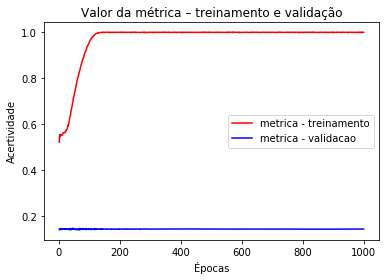

In [23]:
rna1.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna1.plot()

Confusion matrix, without normalization
[[9408 1386]
 [1592 1423]]


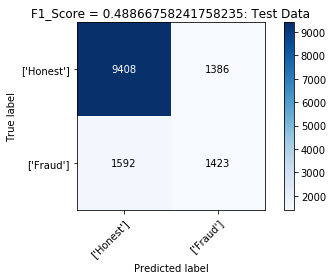

Confusion matrix, without normalization
[[9361 1434]
 [1545 1470]]


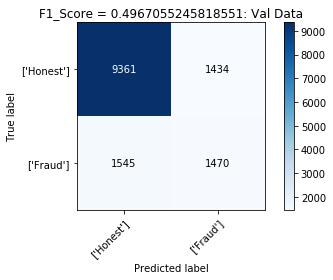

Confusion matrix, without normalization
[[50372     0]
 [    0 14068]]


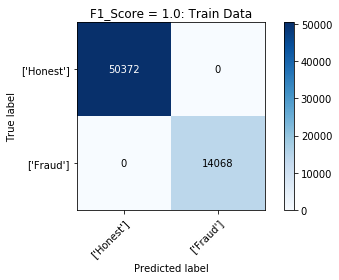

In [24]:
rna1.predict(x_data,y_data)

In [25]:
n_list2 = [50,50,1]
activation_list2 = ['tanh','tanh','sigmoid']

In [26]:
rna2 = new_rna()
rna2.build_model(data_shape,n_list2,activation_list2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 12,651
Trainable params: 12,651
Non-trainable params: 0
_________________________________________________________________


Train on 64440 samples, validate on 13810 samples
Epoch 1/1000
64440/64440 [==============================] - 2s 38us/step - loss: 0.3872 - f1: 0.5038 - val_loss: 0.3690 - val_f1: 0.1419
Epoch 2/1000
64440/64440 [==============================] - 2s 37us/step - loss: 0.3632 - f1: 0.5566 - val_loss: 0.3690 - val_f1: 0.1468
Epoch 3/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.3619 - f1: 0.5562 - val_loss: 0.3702 - val_f1: 0.1433
Epoch 4/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.3610 - f1: 0.5575 - val_loss: 0.3688 - val_f1: 0.1422
Epoch 5/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.3597 - f1: 0.5570 - val_loss: 0.3694 - val_f1: 0.1457
Epoch 6/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.3586 - f1: 0.5573 - val_loss: 0.3675 - val_f1: 0.1438
Epoch 7/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.3575 - f1: 0.5588 - val_loss: 0.3685 - val_f1

64440/64440 [==============================] - 2s 33us/step - loss: 0.2107 - f1: 0.7803 - val_loss: 0.5530 - val_f1: 0.1444
Epoch 61/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.2077 - f1: 0.7845 - val_loss: 0.5624 - val_f1: 0.1443
Epoch 62/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.2050 - f1: 0.7858 - val_loss: 0.5691 - val_f1: 0.1425
Epoch 63/1000
64440/64440 [==============================] - 2s 36us/step - loss: 0.2019 - f1: 0.7900 - val_loss: 0.5788 - val_f1: 0.1436
Epoch 64/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.1990 - f1: 0.7938 - val_loss: 0.5833 - val_f1: 0.1442
Epoch 65/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.1964 - f1: 0.7970 - val_loss: 0.5830 - val_f1: 0.1435
Epoch 66/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.1934 - f1: 0.7993 - val_loss: 0.5978 - val_f1: 0.1440
Epoch 67/1000
64440/64440 [=====================

64440/64440 [==============================] - 2s 32us/step - loss: 0.0871 - f1: 0.9302 - val_loss: 1.0662 - val_f1: 0.1411
Epoch 120/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0858 - f1: 0.9279 - val_loss: 1.0761 - val_f1: 0.1401
Epoch 121/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0845 - f1: 0.9296 - val_loss: 1.0862 - val_f1: 0.1413
Epoch 122/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0827 - f1: 0.9345 - val_loss: 1.0968 - val_f1: 0.1400
Epoch 123/1000
64440/64440 [==============================] - 2s 36us/step - loss: 0.0815 - f1: 0.9360 - val_loss: 1.1078 - val_f1: 0.1410
Epoch 124/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0803 - f1: 0.9377 - val_loss: 1.1140 - val_f1: 0.1390
Epoch 125/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0791 - f1: 0.9356 - val_loss: 1.1249 - val_f1: 0.1409
Epoch 126/1000
64440/64440 [==============

64440/64440 [==============================] - 2s 32us/step - loss: 0.0305 - f1: 0.9897 - val_loss: 1.5717 - val_f1: 0.1411
Epoch 179/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0302 - f1: 0.9912 - val_loss: 1.5781 - val_f1: 0.1418
Epoch 180/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0298 - f1: 0.9915 - val_loss: 1.5843 - val_f1: 0.1409
Epoch 181/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0290 - f1: 0.9925 - val_loss: 1.5896 - val_f1: 0.1422
Epoch 182/1000
64440/64440 [==============================] - 2s 36us/step - loss: 0.0283 - f1: 0.9945 - val_loss: 1.5954 - val_f1: 0.1426
Epoch 183/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0281 - f1: 0.9934 - val_loss: 1.6000 - val_f1: 0.1419
Epoch 184/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0276 - f1: 0.9939 - val_loss: 1.6079 - val_f1: 0.1414
Epoch 185/1000
64440/64440 [==============

64440/64440 [==============================] - 2s 33us/step - loss: 0.0123 - f1: 0.9993 - val_loss: 1.8637 - val_f1: 0.1410
Epoch 238/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0121 - f1: 0.9997 - val_loss: 1.8661 - val_f1: 0.1408
Epoch 239/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0121 - f1: 0.9996 - val_loss: 1.8726 - val_f1: 0.1410
Epoch 240/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0119 - f1: 0.9999 - val_loss: 1.8746 - val_f1: 0.1416
Epoch 241/1000
64440/64440 [==============================] - 2s 35us/step - loss: 0.0117 - f1: 0.9998 - val_loss: 1.8796 - val_f1: 0.1414
Epoch 242/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0116 - f1: 0.9998 - val_loss: 1.8836 - val_f1: 0.1413
Epoch 243/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0114 - f1: 0.9998 - val_loss: 1.8855 - val_f1: 0.1408
Epoch 244/1000
64440/64440 [==============

64440/64440 [==============================] - 2s 35us/step - loss: 0.0069 - f1: 1.0000 - val_loss: 2.0219 - val_f1: 0.1408
Epoch 297/1000
64440/64440 [==============================] - 2s 34us/step - loss: 0.0068 - f1: 1.0000 - val_loss: 2.0265 - val_f1: 0.1412
Epoch 298/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0068 - f1: 1.0000 - val_loss: 2.0266 - val_f1: 0.1412
Epoch 299/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0067 - f1: 0.9994 - val_loss: 2.0298 - val_f1: 0.1406
Epoch 300/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0066 - f1: 0.9995 - val_loss: 2.0309 - val_f1: 0.1413
Epoch 301/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0066 - f1: 0.9990 - val_loss: 2.0319 - val_f1: 0.1408
Epoch 302/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0065 - f1: 0.9995 - val_loss: 2.0367 - val_f1: 0.1413
Epoch 303/1000
64440/64440 [==============

64440/64440 [==============================] - 2s 35us/step - loss: 0.0046 - f1: 1.0000 - val_loss: 2.1195 - val_f1: 0.1414
Epoch 356/1000
64440/64440 [==============================] - 2s 35us/step - loss: 0.0046 - f1: 0.9985 - val_loss: 2.1225 - val_f1: 0.1412
Epoch 357/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0045 - f1: 0.9995 - val_loss: 2.1225 - val_f1: 0.1415
Epoch 358/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0045 - f1: 0.9999 - val_loss: 2.1252 - val_f1: 0.1416
Epoch 359/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0045 - f1: 0.9990 - val_loss: 2.1259 - val_f1: 0.1414
Epoch 360/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0045 - f1: 0.9995 - val_loss: 2.1271 - val_f1: 0.1412
Epoch 361/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0044 - f1: 0.9995 - val_loss: 2.1283 - val_f1: 0.1412
Epoch 362/1000
64440/64440 [==============

64440/64440 [==============================] - 3s 45us/step - loss: 0.0034 - f1: 0.9995 - val_loss: 2.1898 - val_f1: 0.1407
Epoch 415/1000
64440/64440 [==============================] - 2s 36us/step - loss: 0.0034 - f1: 0.9985 - val_loss: 2.1909 - val_f1: 0.1407
Epoch 416/1000
64440/64440 [==============================] - 2s 39us/step - loss: 0.0034 - f1: 1.0000 - val_loss: 2.1930 - val_f1: 0.1409
Epoch 417/1000
64440/64440 [==============================] - 3s 39us/step - loss: 0.0033 - f1: 1.0000 - val_loss: 2.1928 - val_f1: 0.1407
Epoch 418/1000
64440/64440 [==============================] - 2s 35us/step - loss: 0.0033 - f1: 1.0000 - val_loss: 2.1943 - val_f1: 0.1406
Epoch 419/1000
64440/64440 [==============================] - 2s 35us/step - loss: 0.0033 - f1: 0.9994 - val_loss: 2.1956 - val_f1: 0.1408
Epoch 420/1000
64440/64440 [==============================] - 2s 34us/step - loss: 0.0033 - f1: 0.9995 - val_loss: 2.1969 - val_f1: 0.1409
Epoch 421/1000
64440/64440 [==============

64440/64440 [==============================] - 2s 33us/step - loss: 0.0027 - f1: 0.9995 - val_loss: 2.2424 - val_f1: 0.1407
Epoch 474/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0027 - f1: 0.9995 - val_loss: 2.2438 - val_f1: 0.1412
Epoch 475/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0026 - f1: 0.9994 - val_loss: 2.2446 - val_f1: 0.1406
Epoch 476/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0026 - f1: 1.0000 - val_loss: 2.2452 - val_f1: 0.1409
Epoch 477/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0026 - f1: 0.9985 - val_loss: 2.2468 - val_f1: 0.1405
Epoch 478/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0026 - f1: 1.0000 - val_loss: 2.2470 - val_f1: 0.1408
Epoch 479/1000
64440/64440 [==============================] - 2s 35us/step - loss: 0.0026 - f1: 0.9985 - val_loss: 2.2478 - val_f1: 0.1406
Epoch 480/1000
64440/64440 [==============

64440/64440 [==============================] - 2s 33us/step - loss: 0.0022 - f1: 0.9995 - val_loss: 2.2841 - val_f1: 0.1408
Epoch 533/1000
64440/64440 [==============================] - 2s 34us/step - loss: 0.0022 - f1: 1.0000 - val_loss: 2.2843 - val_f1: 0.1408
Epoch 534/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0022 - f1: 0.9999 - val_loss: 2.2859 - val_f1: 0.1406
Epoch 535/1000
64440/64440 [==============================] - 2s 34us/step - loss: 0.0022 - f1: 0.9990 - val_loss: 2.2859 - val_f1: 0.1406
Epoch 536/1000
64440/64440 [==============================] - 2s 35us/step - loss: 0.0022 - f1: 0.9999 - val_loss: 2.2866 - val_f1: 0.1405
Epoch 537/1000
64440/64440 [==============================] - 2s 38us/step - loss: 0.0022 - f1: 0.9995 - val_loss: 2.2877 - val_f1: 0.1403
Epoch 538/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0021 - f1: 1.0000 - val_loss: 2.2882 - val_f1: 0.1407
Epoch 539/1000
64440/64440 [==============

64440/64440 [==============================] - 2s 35us/step - loss: 0.0018 - f1: 0.9995 - val_loss: 2.3179 - val_f1: 0.1406
Epoch 592/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0018 - f1: 0.9995 - val_loss: 2.3175 - val_f1: 0.1403
Epoch 593/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0018 - f1: 1.0000 - val_loss: 2.3183 - val_f1: 0.1405
Epoch 594/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0018 - f1: 0.9995 - val_loss: 2.3190 - val_f1: 0.1402
Epoch 595/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0018 - f1: 1.0000 - val_loss: 2.3197 - val_f1: 0.1404
Epoch 596/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0018 - f1: 0.9995 - val_loss: 2.3201 - val_f1: 0.1406
Epoch 597/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0018 - f1: 1.0000 - val_loss: 2.3206 - val_f1: 0.1405
Epoch 598/1000
64440/64440 [==============

64440/64440 [==============================] - 2s 33us/step - loss: 0.0016 - f1: 0.9990 - val_loss: 2.3449 - val_f1: 0.1406
Epoch 651/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0016 - f1: 0.9995 - val_loss: 2.3456 - val_f1: 0.1405
Epoch 652/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0016 - f1: 0.9995 - val_loss: 2.3462 - val_f1: 0.1405
Epoch 653/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0016 - f1: 1.0000 - val_loss: 2.3456 - val_f1: 0.1405
Epoch 654/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0016 - f1: 0.9990 - val_loss: 2.3463 - val_f1: 0.1403
Epoch 655/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0016 - f1: 0.9985 - val_loss: 2.3472 - val_f1: 0.1404
Epoch 656/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0016 - f1: 1.0000 - val_loss: 2.3478 - val_f1: 0.1406
Epoch 657/1000
64440/64440 [==============

64440/64440 [==============================] - 2s 33us/step - loss: 0.0014 - f1: 0.9995 - val_loss: 2.3678 - val_f1: 0.1403
Epoch 710/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0014 - f1: 0.9985 - val_loss: 2.3681 - val_f1: 0.1404
Epoch 711/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0014 - f1: 0.9995 - val_loss: 2.3682 - val_f1: 0.1402
Epoch 712/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0014 - f1: 1.0000 - val_loss: 2.3685 - val_f1: 0.1404
Epoch 713/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0014 - f1: 1.0000 - val_loss: 2.3695 - val_f1: 0.1404
Epoch 714/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0014 - f1: 1.0000 - val_loss: 2.3694 - val_f1: 0.1403
Epoch 715/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0014 - f1: 1.0000 - val_loss: 2.3696 - val_f1: 0.1401
Epoch 716/1000
64440/64440 [==============

64440/64440 [==============================] - 2s 33us/step - loss: 0.0012 - f1: 1.0000 - val_loss: 2.3877 - val_f1: 0.1404
Epoch 769/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0012 - f1: 1.0000 - val_loss: 2.3881 - val_f1: 0.1405
Epoch 770/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0012 - f1: 0.9995 - val_loss: 2.3882 - val_f1: 0.1406
Epoch 771/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0012 - f1: 1.0000 - val_loss: 2.3885 - val_f1: 0.1402
Epoch 772/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0012 - f1: 0.9995 - val_loss: 2.3892 - val_f1: 0.1402
Epoch 773/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0012 - f1: 1.0000 - val_loss: 2.3891 - val_f1: 0.1403
Epoch 774/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0012 - f1: 0.9995 - val_loss: 2.3896 - val_f1: 0.1403
Epoch 775/1000
64440/64440 [==============

64440/64440 [==============================] - 2s 33us/step - loss: 0.0011 - f1: 0.9995 - val_loss: 2.4058 - val_f1: 0.1404
Epoch 828/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0011 - f1: 1.0000 - val_loss: 2.4054 - val_f1: 0.1405
Epoch 829/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0011 - f1: 1.0000 - val_loss: 2.4057 - val_f1: 0.1405
Epoch 830/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0011 - f1: 1.0000 - val_loss: 2.4057 - val_f1: 0.1404
Epoch 831/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0011 - f1: 0.9985 - val_loss: 2.4061 - val_f1: 0.1405
Epoch 832/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0011 - f1: 0.9985 - val_loss: 2.4064 - val_f1: 0.1403
Epoch 833/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0011 - f1: 1.0000 - val_loss: 2.4067 - val_f1: 0.1405
Epoch 834/1000
64440/64440 [==============

64440/64440 [==============================] - 2s 33us/step - loss: 0.0010 - f1: 0.9995 - val_loss: 2.4209 - val_f1: 0.1406
Epoch 887/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0010 - f1: 1.0000 - val_loss: 2.4206 - val_f1: 0.1406
Epoch 888/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0010 - f1: 0.9995 - val_loss: 2.4213 - val_f1: 0.1406
Epoch 889/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0010 - f1: 1.0000 - val_loss: 2.4214 - val_f1: 0.1407
Epoch 890/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0010 - f1: 1.0000 - val_loss: 2.4219 - val_f1: 0.1406
Epoch 891/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0010 - f1: 1.0000 - val_loss: 2.4220 - val_f1: 0.1406
Epoch 892/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0010 - f1: 1.0000 - val_loss: 2.4222 - val_f1: 0.1406
Epoch 893/1000
64440/64440 [==============

Epoch 944/1000
64440/64440 [==============================] - 2s 33us/step - loss: 9.3445e-04 - f1: 1.0000 - val_loss: 2.4351 - val_f1: 0.1406
Epoch 945/1000
64440/64440 [==============================] - 2s 33us/step - loss: 9.3285e-04 - f1: 1.0000 - val_loss: 2.4352 - val_f1: 0.1405
Epoch 946/1000
64440/64440 [==============================] - 2s 33us/step - loss: 9.3189e-04 - f1: 1.0000 - val_loss: 2.4355 - val_f1: 0.1405
Epoch 947/1000
64440/64440 [==============================] - 2s 34us/step - loss: 9.3037e-04 - f1: 0.9990 - val_loss: 2.4353 - val_f1: 0.1405
Epoch 948/1000
64440/64440 [==============================] - 2s 34us/step - loss: 9.2903e-04 - f1: 1.0000 - val_loss: 2.4359 - val_f1: 0.1405
Epoch 949/1000
64440/64440 [==============================] - 2s 34us/step - loss: 9.2802e-04 - f1: 0.9995 - val_loss: 2.4359 - val_f1: 0.1405
Epoch 950/1000
64440/64440 [==============================] - 2s 34us/step - loss: 9.2650e-04 - f1: 0.9995 - val_loss: 2.4360 - val_f1: 0.1405

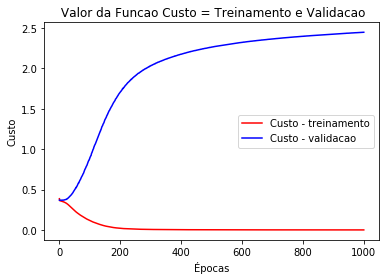

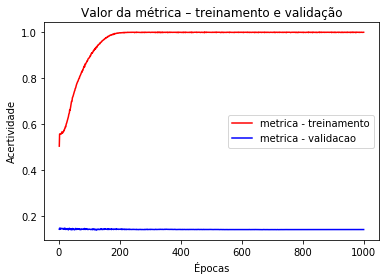

In [27]:
rna2.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna2.plot()

Confusion matrix, without normalization
[[9238 1556]
 [1574 1441]]


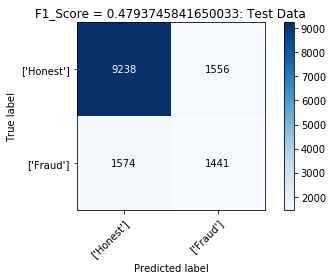

Confusion matrix, without normalization
[[9164 1631]
 [1568 1447]]


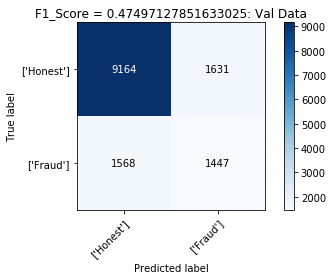

Confusion matrix, without normalization
[[50372     0]
 [    0 14068]]


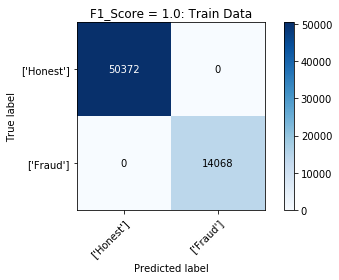

In [28]:
rna2.predict(x_data,y_data)

In [29]:
n_list3 = [100,100,1]
activation_list3 = ['tanh', 'tanh', 'sigmoid']

In [30]:
rna3 = new_rna()
rna3.build_model(data_shape,n_list3,activation_list3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 30,301
Trainable params: 30,301
Non-trainable params: 0
_________________________________________________________________


Train on 64440 samples, validate on 13810 samples
Epoch 1/1000
64440/64440 [==============================] - 3s 44us/step - loss: 0.3885 - f1: 0.4960 - val_loss: 0.3713 - val_f1: 0.1419
Epoch 2/1000
64440/64440 [==============================] - 2s 34us/step - loss: 0.3631 - f1: 0.5518 - val_loss: 0.3690 - val_f1: 0.1376
Epoch 3/1000
64440/64440 [==============================] - 2s 34us/step - loss: 0.3618 - f1: 0.5488 - val_loss: 0.3680 - val_f1: 0.1439
Epoch 4/1000
64440/64440 [==============================] - 2s 35us/step - loss: 0.3607 - f1: 0.5530 - val_loss: 0.3688 - val_f1: 0.1428
Epoch 5/1000
64440/64440 [==============================] - 2s 34us/step - loss: 0.3596 - f1: 0.5550 - val_loss: 0.3684 - val_f1: 0.1433
Epoch 6/1000
64440/64440 [==============================] - 2s 34us/step - loss: 0.3587 - f1: 0.5573 - val_loss: 0.3676 - val_f1: 0.1430
Epoch 7/1000
64440/64440 [==============================] - 2s 36us/step - loss: 0.3579 - f1: 0.5535 - val_loss: 0.3674 - val_f1

64440/64440 [==============================] - 2s 37us/step - loss: 0.0991 - f1: 0.9170 - val_loss: 0.7724 - val_f1: 0.1470
Epoch 61/1000
64440/64440 [==============================] - 2s 39us/step - loss: 0.0931 - f1: 0.9229 - val_loss: 0.7906 - val_f1: 0.1405
Epoch 62/1000
64440/64440 [==============================] - 2s 38us/step - loss: 0.0873 - f1: 0.9300 - val_loss: 0.8151 - val_f1: 0.1453
Epoch 63/1000
64440/64440 [==============================] - 2s 34us/step - loss: 0.0824 - f1: 0.9337 - val_loss: 0.8267 - val_f1: 0.1444
Epoch 64/1000
64440/64440 [==============================] - 2s 37us/step - loss: 0.0777 - f1: 0.9442 - val_loss: 0.8485 - val_f1: 0.1418
Epoch 65/1000
64440/64440 [==============================] - 3s 44us/step - loss: 0.0718 - f1: 0.9482 - val_loss: 0.8837 - val_f1: 0.1448
Epoch 66/1000
64440/64440 [==============================] - 3s 43us/step - loss: 0.0675 - f1: 0.9528 - val_loss: 0.8974 - val_f1: 0.1446
Epoch 67/1000
64440/64440 [=====================

64440/64440 [==============================] - 2s 32us/step - loss: 0.0039 - f1: 0.9995 - val_loss: 1.6197 - val_f1: 0.1420
Epoch 120/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0038 - f1: 0.9995 - val_loss: 1.6273 - val_f1: 0.1411
Epoch 121/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0037 - f1: 0.9995 - val_loss: 1.6336 - val_f1: 0.1425
Epoch 122/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0036 - f1: 1.0000 - val_loss: 1.6386 - val_f1: 0.1421
Epoch 123/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0035 - f1: 1.0000 - val_loss: 1.6431 - val_f1: 0.1407
Epoch 124/1000
64440/64440 [==============================] - 2s 36us/step - loss: 0.0034 - f1: 1.0000 - val_loss: 1.6489 - val_f1: 0.1420
Epoch 125/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0033 - f1: 0.9995 - val_loss: 1.6546 - val_f1: 0.1420
Epoch 126/1000
64440/64440 [==============

64440/64440 [==============================] - 3s 49us/step - loss: 0.0014 - f1: 0.9995 - val_loss: 1.8406 - val_f1: 0.1416
Epoch 179/1000
64440/64440 [==============================] - 4s 54us/step - loss: 0.0014 - f1: 0.9990 - val_loss: 1.8443 - val_f1: 0.1408
Epoch 180/1000
64440/64440 [==============================] - 3s 47us/step - loss: 0.0013 - f1: 1.0000 - val_loss: 1.8469 - val_f1: 0.1413
Epoch 181/1000
64440/64440 [==============================] - 3s 51us/step - loss: 0.0013 - f1: 1.0000 - val_loss: 1.8482 - val_f1: 0.1414
Epoch 182/1000
64440/64440 [==============================] - 4s 64us/step - loss: 0.0013 - f1: 1.0000 - val_loss: 1.8498 - val_f1: 0.1413
Epoch 183/1000
64440/64440 [==============================] - 3s 48us/step - loss: 0.0013 - f1: 1.0000 - val_loss: 1.8526 - val_f1: 0.1413
Epoch 184/1000
64440/64440 [==============================] - 2s 38us/step - loss: 0.0013 - f1: 0.9995 - val_loss: 1.8540 - val_f1: 0.1417
Epoch 185/1000
64440/64440 [==============

64440/64440 [==============================] - 3s 45us/step - loss: 7.9037e-04 - f1: 1.0000 - val_loss: 1.9475 - val_f1: 0.1412
Epoch 237/1000
64440/64440 [==============================] - 3s 44us/step - loss: 7.8353e-04 - f1: 1.0000 - val_loss: 1.9490 - val_f1: 0.1412
Epoch 238/1000
64440/64440 [==============================] - 3s 43us/step - loss: 7.7694e-04 - f1: 1.0000 - val_loss: 1.9501 - val_f1: 0.1417
Epoch 239/1000
64440/64440 [==============================] - 3s 43us/step - loss: 7.7191e-04 - f1: 0.9995 - val_loss: 1.9525 - val_f1: 0.1416
Epoch 240/1000
64440/64440 [==============================] - 3s 47us/step - loss: 7.6517e-04 - f1: 0.9995 - val_loss: 1.9524 - val_f1: 0.1414
Epoch 241/1000
64440/64440 [==============================] - 3s 43us/step - loss: 7.6021e-04 - f1: 0.9995 - val_loss: 1.9547 - val_f1: 0.1412
Epoch 242/1000
64440/64440 [==============================] - 3s 46us/step - loss: 7.5460e-04 - f1: 1.0000 - val_loss: 1.9556 - val_f1: 0.1415
Epoch 243/1000

64440/64440 [==============================] - 3s 43us/step - loss: 5.3871e-04 - f1: 1.0000 - val_loss: 2.0147 - val_f1: 0.1414
Epoch 294/1000
64440/64440 [==============================] - 3s 48us/step - loss: 5.3565e-04 - f1: 0.9995 - val_loss: 2.0149 - val_f1: 0.1410
Epoch 295/1000
64440/64440 [==============================] - 3s 46us/step - loss: 5.3208e-04 - f1: 0.9995 - val_loss: 2.0165 - val_f1: 0.1410
Epoch 296/1000
64440/64440 [==============================] - 3s 47us/step - loss: 5.2934e-04 - f1: 0.9995 - val_loss: 2.0167 - val_f1: 0.1410
Epoch 297/1000
64440/64440 [==============================] - 3s 48us/step - loss: 5.2591e-04 - f1: 0.9995 - val_loss: 2.0188 - val_f1: 0.1415
Epoch 298/1000
64440/64440 [==============================] - 3s 47us/step - loss: 5.2336e-04 - f1: 0.9990 - val_loss: 2.0191 - val_f1: 0.1410
Epoch 299/1000
64440/64440 [==============================] - 3s 46us/step - loss: 5.2005e-04 - f1: 1.0000 - val_loss: 2.0210 - val_f1: 0.1409
Epoch 300/1000

64440/64440 [==============================] - 3s 52us/step - loss: 4.0123e-04 - f1: 1.0000 - val_loss: 2.0631 - val_f1: 0.1411
Epoch 351/1000
64440/64440 [==============================] - 3s 44us/step - loss: 3.9938e-04 - f1: 1.0000 - val_loss: 2.0634 - val_f1: 0.1412
Epoch 352/1000
64440/64440 [==============================] - 3s 44us/step - loss: 3.9767e-04 - f1: 0.9995 - val_loss: 2.0644 - val_f1: 0.1412
Epoch 353/1000
64440/64440 [==============================] - 2s 37us/step - loss: 3.9560e-04 - f1: 1.0000 - val_loss: 2.0654 - val_f1: 0.1413
Epoch 354/1000
64440/64440 [==============================] - 2s 36us/step - loss: 3.9389e-04 - f1: 0.9995 - val_loss: 2.0660 - val_f1: 0.1411
Epoch 355/1000
64440/64440 [==============================] - 3s 52us/step - loss: 3.9215e-04 - f1: 1.0000 - val_loss: 2.0668 - val_f1: 0.1410
Epoch 356/1000
64440/64440 [==============================] - 3s 46us/step - loss: 3.9027e-04 - f1: 0.9990 - val_loss: 2.0668 - val_f1: 0.1412
Epoch 357/1000

64440/64440 [==============================] - 2s 33us/step - loss: 3.1615e-04 - f1: 0.9990 - val_loss: 2.1004 - val_f1: 0.1414
Epoch 408/1000
64440/64440 [==============================] - 2s 34us/step - loss: 3.1460e-04 - f1: 1.0000 - val_loss: 2.1010 - val_f1: 0.1416
Epoch 409/1000
64440/64440 [==============================] - 2s 34us/step - loss: 3.1371e-04 - f1: 0.9990 - val_loss: 2.1015 - val_f1: 0.1414
Epoch 410/1000
64440/64440 [==============================] - 2s 35us/step - loss: 3.1231e-04 - f1: 0.9995 - val_loss: 2.1027 - val_f1: 0.1416
Epoch 411/1000
64440/64440 [==============================] - 2s 35us/step - loss: 3.1131e-04 - f1: 1.0000 - val_loss: 2.1029 - val_f1: 0.1415
Epoch 412/1000
64440/64440 [==============================] - 2s 35us/step - loss: 3.1008e-04 - f1: 1.0000 - val_loss: 2.1031 - val_f1: 0.1414
Epoch 413/1000
64440/64440 [==============================] - 2s 33us/step - loss: 3.0898e-04 - f1: 0.9995 - val_loss: 2.1035 - val_f1: 0.1414
Epoch 414/1000

64440/64440 [==============================] - 2s 33us/step - loss: 2.5862e-04 - f1: 1.0000 - val_loss: 2.1308 - val_f1: 0.1414
Epoch 465/1000
64440/64440 [==============================] - 2s 35us/step - loss: 2.5784e-04 - f1: 0.9985 - val_loss: 2.1311 - val_f1: 0.1415
Epoch 466/1000
64440/64440 [==============================] - 2s 34us/step - loss: 2.5713e-04 - f1: 0.9995 - val_loss: 2.1319 - val_f1: 0.1413
Epoch 467/1000
64440/64440 [==============================] - 2s 34us/step - loss: 2.5629e-04 - f1: 1.0000 - val_loss: 2.1324 - val_f1: 0.1415
Epoch 468/1000
64440/64440 [==============================] - 2s 33us/step - loss: 2.5532e-04 - f1: 0.9995 - val_loss: 2.1324 - val_f1: 0.1414
Epoch 469/1000
64440/64440 [==============================] - 2s 34us/step - loss: 2.5451e-04 - f1: 0.9995 - val_loss: 2.1332 - val_f1: 0.1413
Epoch 470/1000
64440/64440 [==============================] - 2s 37us/step - loss: 2.5377e-04 - f1: 1.0000 - val_loss: 2.1339 - val_f1: 0.1413
Epoch 471/1000

64440/64440 [==============================] - 2s 34us/step - loss: 2.1782e-04 - f1: 1.0000 - val_loss: 2.1564 - val_f1: 0.1414
Epoch 522/1000
64440/64440 [==============================] - 2s 34us/step - loss: 2.1720e-04 - f1: 0.9995 - val_loss: 2.1563 - val_f1: 0.1415
Epoch 523/1000
64440/64440 [==============================] - 2s 34us/step - loss: 2.1653e-04 - f1: 0.9995 - val_loss: 2.1564 - val_f1: 0.1414
Epoch 524/1000
64440/64440 [==============================] - 2s 34us/step - loss: 2.1598e-04 - f1: 1.0000 - val_loss: 2.1569 - val_f1: 0.1412
Epoch 525/1000
64440/64440 [==============================] - 2s 34us/step - loss: 2.1537e-04 - f1: 0.9995 - val_loss: 2.1577 - val_f1: 0.1413
Epoch 526/1000
64440/64440 [==============================] - 2s 35us/step - loss: 2.1476e-04 - f1: 0.9995 - val_loss: 2.1582 - val_f1: 0.1414
Epoch 527/1000
64440/64440 [==============================] - 2s 37us/step - loss: 2.1422e-04 - f1: 0.9995 - val_loss: 2.1586 - val_f1: 0.1414
Epoch 528/1000

64440/64440 [==============================] - 2s 37us/step - loss: 1.8736e-04 - f1: 0.9985 - val_loss: 2.1776 - val_f1: 0.1410
Epoch 579/1000
64440/64440 [==============================] - 2s 34us/step - loss: 1.8686e-04 - f1: 0.9990 - val_loss: 2.1782 - val_f1: 0.1410
Epoch 580/1000
64440/64440 [==============================] - 2s 34us/step - loss: 1.8639e-04 - f1: 0.9995 - val_loss: 2.1779 - val_f1: 0.1409
Epoch 581/1000
64440/64440 [==============================] - 2s 34us/step - loss: 1.8592e-04 - f1: 0.9985 - val_loss: 2.1784 - val_f1: 0.1411
Epoch 582/1000
64440/64440 [==============================] - 2s 34us/step - loss: 1.8550e-04 - f1: 0.9995 - val_loss: 2.1791 - val_f1: 0.1412
Epoch 583/1000
64440/64440 [==============================] - 2s 34us/step - loss: 1.8502e-04 - f1: 1.0000 - val_loss: 2.1793 - val_f1: 0.1410
Epoch 584/1000
64440/64440 [==============================] - 2s 34us/step - loss: 1.8458e-04 - f1: 1.0000 - val_loss: 2.1799 - val_f1: 0.1412
Epoch 585/1000

64440/64440 [==============================] - 2s 34us/step - loss: 1.6386e-04 - f1: 0.9995 - val_loss: 2.1962 - val_f1: 0.1407
Epoch 636/1000
64440/64440 [==============================] - 2s 37us/step - loss: 1.6345e-04 - f1: 1.0000 - val_loss: 2.1964 - val_f1: 0.1407
Epoch 637/1000
64440/64440 [==============================] - 2s 33us/step - loss: 1.6310e-04 - f1: 0.9995 - val_loss: 2.1967 - val_f1: 0.1409
Epoch 638/1000
64440/64440 [==============================] - 2s 33us/step - loss: 1.6273e-04 - f1: 0.9990 - val_loss: 2.1972 - val_f1: 0.1408
Epoch 639/1000
64440/64440 [==============================] - 2s 33us/step - loss: 1.6236e-04 - f1: 1.0000 - val_loss: 2.1972 - val_f1: 0.1407
Epoch 640/1000
64440/64440 [==============================] - 2s 34us/step - loss: 1.6202e-04 - f1: 0.9990 - val_loss: 2.1978 - val_f1: 0.1408
Epoch 641/1000
64440/64440 [==============================] - 2s 34us/step - loss: 1.6165e-04 - f1: 1.0000 - val_loss: 2.1985 - val_f1: 0.1408
Epoch 642/1000

64440/64440 [==============================] - 2s 34us/step - loss: 1.4525e-04 - f1: 0.9995 - val_loss: 2.2132 - val_f1: 0.1406
Epoch 693/1000
64440/64440 [==============================] - 2s 34us/step - loss: 1.4494e-04 - f1: 1.0000 - val_loss: 2.2133 - val_f1: 0.1405
Epoch 694/1000
64440/64440 [==============================] - 2s 37us/step - loss: 1.4463e-04 - f1: 1.0000 - val_loss: 2.2137 - val_f1: 0.1405
Epoch 695/1000
64440/64440 [==============================] - 2s 33us/step - loss: 1.4437e-04 - f1: 1.0000 - val_loss: 2.2136 - val_f1: 0.1406
Epoch 696/1000
64440/64440 [==============================] - 2s 33us/step - loss: 1.4406e-04 - f1: 1.0000 - val_loss: 2.2142 - val_f1: 0.1406
Epoch 697/1000
64440/64440 [==============================] - 2s 34us/step - loss: 1.4379e-04 - f1: 0.9995 - val_loss: 2.2141 - val_f1: 0.1406
Epoch 698/1000
64440/64440 [==============================] - 2s 34us/step - loss: 1.4350e-04 - f1: 1.0000 - val_loss: 2.2148 - val_f1: 0.1405
Epoch 699/1000

64440/64440 [==============================] - 2s 34us/step - loss: 1.3021e-04 - f1: 0.9995 - val_loss: 2.2277 - val_f1: 0.1405
Epoch 750/1000
64440/64440 [==============================] - 2s 34us/step - loss: 1.2995e-04 - f1: 0.9995 - val_loss: 2.2281 - val_f1: 0.1405
Epoch 751/1000
64440/64440 [==============================] - 2s 34us/step - loss: 1.2972e-04 - f1: 1.0000 - val_loss: 2.2284 - val_f1: 0.1406
Epoch 752/1000
64440/64440 [==============================] - 2s 34us/step - loss: 1.2945e-04 - f1: 0.9990 - val_loss: 2.2283 - val_f1: 0.1405
Epoch 753/1000
64440/64440 [==============================] - 2s 37us/step - loss: 1.2925e-04 - f1: 0.9990 - val_loss: 2.2287 - val_f1: 0.1405
Epoch 754/1000
64440/64440 [==============================] - 2s 33us/step - loss: 1.2900e-04 - f1: 1.0000 - val_loss: 2.2290 - val_f1: 0.1405
Epoch 755/1000
64440/64440 [==============================] - 2s 34us/step - loss: 1.2879e-04 - f1: 0.9995 - val_loss: 2.2297 - val_f1: 0.1405
Epoch 756/1000

64440/64440 [==============================] - 2s 34us/step - loss: 1.1781e-04 - f1: 0.9990 - val_loss: 2.2412 - val_f1: 0.1403
Epoch 807/1000
64440/64440 [==============================] - 2s 34us/step - loss: 1.1762e-04 - f1: 1.0000 - val_loss: 2.2414 - val_f1: 0.1402
Epoch 808/1000
64440/64440 [==============================] - 2s 34us/step - loss: 1.1745e-04 - f1: 0.9990 - val_loss: 2.2415 - val_f1: 0.1403
Epoch 809/1000
64440/64440 [==============================] - 2s 34us/step - loss: 1.1725e-04 - f1: 0.9991 - val_loss: 2.2420 - val_f1: 0.1402
Epoch 810/1000
64440/64440 [==============================] - 2s 34us/step - loss: 1.1703e-04 - f1: 1.0000 - val_loss: 2.2421 - val_f1: 0.1403
Epoch 811/1000
64440/64440 [==============================] - 2s 37us/step - loss: 1.1685e-04 - f1: 1.0000 - val_loss: 2.2426 - val_f1: 0.1403
Epoch 812/1000
64440/64440 [==============================] - 2s 33us/step - loss: 1.1665e-04 - f1: 1.0000 - val_loss: 2.2428 - val_f1: 0.1403
Epoch 813/1000

64440/64440 [==============================] - 2s 33us/step - loss: 1.0752e-04 - f1: 1.0000 - val_loss: 2.2531 - val_f1: 0.1406
Epoch 864/1000
64440/64440 [==============================] - 2s 34us/step - loss: 1.0735e-04 - f1: 0.9985 - val_loss: 2.2535 - val_f1: 0.1406
Epoch 865/1000
64440/64440 [==============================] - 2s 34us/step - loss: 1.0720e-04 - f1: 1.0000 - val_loss: 2.2539 - val_f1: 0.1405
Epoch 866/1000
64440/64440 [==============================] - 2s 34us/step - loss: 1.0704e-04 - f1: 1.0000 - val_loss: 2.2542 - val_f1: 0.1406
Epoch 867/1000
64440/64440 [==============================] - 2s 34us/step - loss: 1.0686e-04 - f1: 0.9990 - val_loss: 2.2542 - val_f1: 0.1405
Epoch 868/1000
64440/64440 [==============================] - 2s 33us/step - loss: 1.0670e-04 - f1: 1.0000 - val_loss: 2.2547 - val_f1: 0.1406
Epoch 869/1000
64440/64440 [==============================] - 2s 37us/step - loss: 1.0654e-04 - f1: 0.9991 - val_loss: 2.2546 - val_f1: 0.1405
Epoch 870/1000

64440/64440 [==============================] - 2s 37us/step - loss: 9.8840e-05 - f1: 0.9995 - val_loss: 2.2645 - val_f1: 0.1406
Epoch 921/1000
64440/64440 [==============================] - 2s 33us/step - loss: 9.8703e-05 - f1: 1.0000 - val_loss: 2.2649 - val_f1: 0.1406
Epoch 922/1000
64440/64440 [==============================] - 2s 34us/step - loss: 9.8554e-05 - f1: 1.0000 - val_loss: 2.2647 - val_f1: 0.1406
Epoch 923/1000
64440/64440 [==============================] - 2s 34us/step - loss: 9.8422e-05 - f1: 1.0000 - val_loss: 2.2651 - val_f1: 0.1406
Epoch 924/1000
64440/64440 [==============================] - 2s 34us/step - loss: 9.8267e-05 - f1: 1.0000 - val_loss: 2.2646 - val_f1: 0.1406
Epoch 925/1000
64440/64440 [==============================] - 2s 33us/step - loss: 9.8140e-05 - f1: 0.9990 - val_loss: 2.2655 - val_f1: 0.1407
Epoch 926/1000
64440/64440 [==============================] - 2s 33us/step - loss: 9.7989e-05 - f1: 0.9990 - val_loss: 2.2654 - val_f1: 0.1406
Epoch 927/1000

64440/64440 [==============================] - 2s 33us/step - loss: 9.1429e-05 - f1: 1.0000 - val_loss: 2.2743 - val_f1: 0.1405
Epoch 978/1000
64440/64440 [==============================] - 2s 37us/step - loss: 9.1318e-05 - f1: 1.0000 - val_loss: 2.2743 - val_f1: 0.1406
Epoch 979/1000
64440/64440 [==============================] - 2s 34us/step - loss: 9.1184e-05 - f1: 0.9990 - val_loss: 2.2747 - val_f1: 0.1406
Epoch 980/1000
64440/64440 [==============================] - 2s 34us/step - loss: 9.1073e-05 - f1: 0.9995 - val_loss: 2.2747 - val_f1: 0.1406
Epoch 981/1000
64440/64440 [==============================] - 2s 34us/step - loss: 9.0957e-05 - f1: 1.0000 - val_loss: 2.2749 - val_f1: 0.1405
Epoch 982/1000
64440/64440 [==============================] - 2s 33us/step - loss: 9.0827e-05 - f1: 0.9995 - val_loss: 2.2755 - val_f1: 0.1406
Epoch 983/1000
64440/64440 [==============================] - 2s 33us/step - loss: 9.0721e-05 - f1: 1.0000 - val_loss: 2.2755 - val_f1: 0.1406
Epoch 984/1000

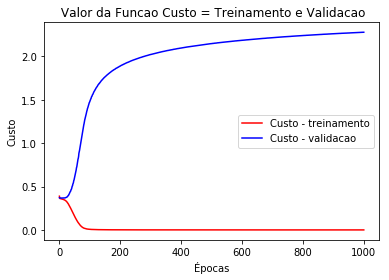

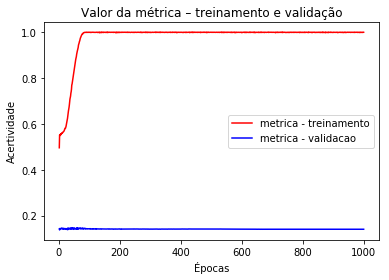

In [31]:
rna3.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna3.plot()

Confusion matrix, without normalization
[[9326 1468]
 [1548 1467]]


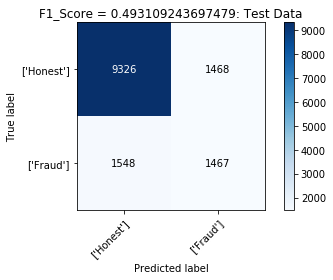

Confusion matrix, without normalization
[[9280 1515]
 [1579 1436]]


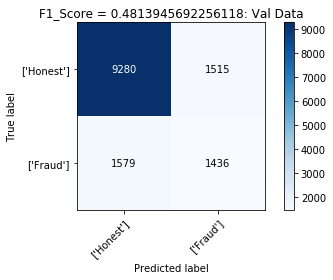

Confusion matrix, without normalization
[[50372     0]
 [    0 14068]]


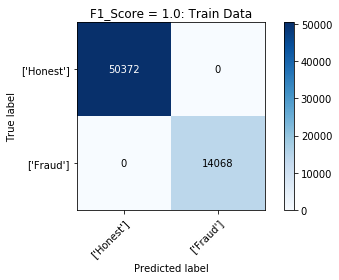

In [32]:
rna3.predict(x_data,y_data)

In [33]:
n_list4 = [50,50,50,1]
activation_list4 = ['tanh','tanh','tanh','sigmoid']

In [34]:
rna4 = new_rna()
rna4.build_model(data_shape,n_list4,activation_list4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 15,201
Trainable params: 15,201
Non-trainable params: 0
_________________________________________________________________


Train on 64440 samples, validate on 13810 samples
Epoch 1/1000
64440/64440 [==============================] - 3s 39us/step - loss: 0.3827 - f1: 0.5076 - val_loss: 0.3697 - val_f1: 0.1394
Epoch 2/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.3635 - f1: 0.5466 - val_loss: 0.3700 - val_f1: 0.1404
Epoch 3/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.3616 - f1: 0.5550 - val_loss: 0.3699 - val_f1: 0.1397
Epoch 4/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.3600 - f1: 0.5569 - val_loss: 0.3705 - val_f1: 0.1466
Epoch 5/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.3587 - f1: 0.5620 - val_loss: 0.3696 - val_f1: 0.1447
Epoch 6/1000
64440/64440 [==============================] - 2s 36us/step - loss: 0.3570 - f1: 0.5584 - val_loss: 0.3683 - val_f1: 0.1447
Epoch 7/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.3559 - f1: 0.5623 - val_loss: 0.3694 - val_f1

Epoch 60/1000
64440/64440 [==============================] - 2s 36us/step - loss: 0.1547 - f1: 0.8491 - val_loss: 0.7814 - val_f1: 0.1407
Epoch 61/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.1513 - f1: 0.8499 - val_loss: 0.8017 - val_f1: 0.1444
Epoch 62/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.1476 - f1: 0.8551 - val_loss: 0.8194 - val_f1: 0.1435
Epoch 63/1000
64440/64440 [==============================] - 2s 34us/step - loss: 0.1450 - f1: 0.8532 - val_loss: 0.8246 - val_f1: 0.1440
Epoch 64/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.1412 - f1: 0.8611 - val_loss: 0.8528 - val_f1: 0.1435
Epoch 65/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.1380 - f1: 0.8662 - val_loss: 0.8665 - val_f1: 0.1422
Epoch 66/1000
64440/64440 [==============================] - 2s 31us/step - loss: 0.1352 - f1: 0.8675 - val_loss: 0.8964 - val_f1: 0.1446
Epoch 67/1000
64440/64440 [=======

64440/64440 [==============================] - 2s 32us/step - loss: 0.0324 - f1: 0.9748 - val_loss: 1.8315 - val_f1: 0.1439
Epoch 120/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0305 - f1: 0.9783 - val_loss: 1.8613 - val_f1: 0.1459
Epoch 121/1000
64440/64440 [==============================] - 2s 35us/step - loss: 0.0302 - f1: 0.9787 - val_loss: 1.8633 - val_f1: 0.1451
Epoch 122/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0289 - f1: 0.9793 - val_loss: 1.8816 - val_f1: 0.1442
Epoch 123/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0286 - f1: 0.9800 - val_loss: 1.8942 - val_f1: 0.1431
Epoch 124/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0303 - f1: 0.9768 - val_loss: 1.9032 - val_f1: 0.1450
Epoch 125/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0301 - f1: 0.9751 - val_loss: 1.9268 - val_f1: 0.1449
Epoch 126/1000
64440/64440 [==============

64440/64440 [==============================] - 2s 32us/step - loss: 0.0019 - f1: 0.9994 - val_loss: 2.3229 - val_f1: 0.1437
Epoch 179/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0019 - f1: 1.0000 - val_loss: 2.3270 - val_f1: 0.1437
Epoch 180/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0019 - f1: 0.9994 - val_loss: 2.3312 - val_f1: 0.1435
Epoch 181/1000
64440/64440 [==============================] - 2s 34us/step - loss: 0.0018 - f1: 1.0000 - val_loss: 2.3359 - val_f1: 0.1438
Epoch 182/1000
64440/64440 [==============================] - 2s 36us/step - loss: 0.0018 - f1: 0.9995 - val_loss: 2.3370 - val_f1: 0.1435
Epoch 183/1000
64440/64440 [==============================] - 2s 33us/step - loss: 0.0018 - f1: 0.9985 - val_loss: 2.3416 - val_f1: 0.1437
Epoch 184/1000
64440/64440 [==============================] - 2s 32us/step - loss: 0.0018 - f1: 0.9999 - val_loss: 2.3455 - val_f1: 0.1436
Epoch 185/1000
64440/64440 [==============

64440/64440 [==============================] - 2s 35us/step - loss: 0.0010 - f1: 0.9995 - val_loss: 2.4750 - val_f1: 0.1440
Epoch 238/1000
64440/64440 [==============================] - 2s 36us/step - loss: 9.9991e-04 - f1: 1.0000 - val_loss: 2.4771 - val_f1: 0.1441
Epoch 239/1000
64440/64440 [==============================] - 2s 37us/step - loss: 9.9241e-04 - f1: 0.9999 - val_loss: 2.4777 - val_f1: 0.1442
Epoch 240/1000
64440/64440 [==============================] - 2s 35us/step - loss: 9.8565e-04 - f1: 0.9995 - val_loss: 2.4799 - val_f1: 0.1440
Epoch 241/1000
64440/64440 [==============================] - 2s 36us/step - loss: 9.7732e-04 - f1: 0.9995 - val_loss: 2.4810 - val_f1: 0.1439
Epoch 242/1000
64440/64440 [==============================] - 3s 40us/step - loss: 9.7117e-04 - f1: 0.9999 - val_loss: 2.4834 - val_f1: 0.1441
Epoch 243/1000
64440/64440 [==============================] - 2s 36us/step - loss: 9.6323e-04 - f1: 0.9985 - val_loss: 2.4852 - val_f1: 0.1441
Epoch 244/1000
644

64440/64440 [==============================] - 4s 57us/step - loss: 7.1800e-04 - f1: 1.0000 - val_loss: 2.5541 - val_f1: 0.1442
Epoch 295/1000
64440/64440 [==============================] - 4s 58us/step - loss: 7.1487e-04 - f1: 0.9995 - val_loss: 2.5540 - val_f1: 0.1440
Epoch 296/1000
64440/64440 [==============================] - 3s 51us/step - loss: 7.1114e-04 - f1: 0.9995 - val_loss: 2.5559 - val_f1: 0.1441
Epoch 297/1000
64440/64440 [==============================] - 3s 49us/step - loss: 7.0797e-04 - f1: 0.9990 - val_loss: 2.5561 - val_f1: 0.1441
Epoch 298/1000
64440/64440 [==============================] - 3s 39us/step - loss: 7.0485e-04 - f1: 0.9999 - val_loss: 2.5572 - val_f1: 0.1442
Epoch 299/1000
64440/64440 [==============================] - 2s 35us/step - loss: 7.0170e-04 - f1: 0.9990 - val_loss: 2.5579 - val_f1: 0.1441
Epoch 300/1000
64440/64440 [==============================] - 2s 36us/step - loss: 6.9903e-04 - f1: 1.0000 - val_loss: 2.5595 - val_f1: 0.1441
Epoch 301/1000

64440/64440 [==============================] - 3s 43us/step - loss: 5.7919e-04 - f1: 0.9990 - val_loss: 2.6050 - val_f1: 0.1437
Epoch 352/1000
64440/64440 [==============================] - 3s 44us/step - loss: 5.7742e-04 - f1: 0.9995 - val_loss: 2.6047 - val_f1: 0.1437
Epoch 353/1000
64440/64440 [==============================] - 3s 43us/step - loss: 5.7545e-04 - f1: 0.9995 - val_loss: 2.6056 - val_f1: 0.1437
Epoch 354/1000
64440/64440 [==============================] - 3s 48us/step - loss: 5.7403e-04 - f1: 0.9995 - val_loss: 2.6069 - val_f1: 0.1438
Epoch 355/1000
64440/64440 [==============================] - 3s 42us/step - loss: 5.7229e-04 - f1: 1.0000 - val_loss: 2.6072 - val_f1: 0.1438
Epoch 356/1000
64440/64440 [==============================] - 3s 41us/step - loss: 5.7055e-04 - f1: 0.9995 - val_loss: 2.6078 - val_f1: 0.1437
Epoch 357/1000
64440/64440 [==============================] - 3s 42us/step - loss: 5.6872e-04 - f1: 0.9990 - val_loss: 2.6085 - val_f1: 0.1438
Epoch 358/1000

64440/64440 [==============================] - 3s 42us/step - loss: 4.9969e-04 - f1: 1.0000 - val_loss: 2.6413 - val_f1: 0.1438
Epoch 409/1000
64440/64440 [==============================] - 3s 42us/step - loss: 4.9872e-04 - f1: 0.9995 - val_loss: 2.6416 - val_f1: 0.1439
Epoch 410/1000
64440/64440 [==============================] - 3s 42us/step - loss: 4.9756e-04 - f1: 0.9995 - val_loss: 2.6425 - val_f1: 0.1439
Epoch 411/1000
64440/64440 [==============================] - 3s 43us/step - loss: 4.9650e-04 - f1: 0.9990 - val_loss: 2.6434 - val_f1: 0.1439
Epoch 412/1000
64440/64440 [==============================] - 3s 47us/step - loss: 4.9547e-04 - f1: 1.0000 - val_loss: 2.6439 - val_f1: 0.1439
Epoch 413/1000
64440/64440 [==============================] - 3s 44us/step - loss: 4.9440e-04 - f1: 1.0000 - val_loss: 2.6439 - val_f1: 0.1439
Epoch 414/1000
64440/64440 [==============================] - 3s 45us/step - loss: 4.9341e-04 - f1: 1.0000 - val_loss: 2.6449 - val_f1: 0.1439
Epoch 415/1000

64440/64440 [==============================] - 3s 42us/step - loss: 4.4907e-04 - f1: 1.0000 - val_loss: 2.6702 - val_f1: 0.1439
Epoch 466/1000
64440/64440 [==============================] - 3s 42us/step - loss: 4.4829e-04 - f1: 0.9995 - val_loss: 2.6708 - val_f1: 0.1439
Epoch 467/1000
64440/64440 [==============================] - 3s 43us/step - loss: 4.4760e-04 - f1: 0.9995 - val_loss: 2.6711 - val_f1: 0.1438
Epoch 468/1000
64440/64440 [==============================] - 3s 48us/step - loss: 4.4692e-04 - f1: 0.9990 - val_loss: 2.6720 - val_f1: 0.1439
Epoch 469/1000
64440/64440 [==============================] - 3s 43us/step - loss: 4.4620e-04 - f1: 0.9995 - val_loss: 2.6723 - val_f1: 0.1439
Epoch 470/1000
64440/64440 [==============================] - 3s 43us/step - loss: 4.4548e-04 - f1: 1.0000 - val_loss: 2.6731 - val_f1: 0.1438
Epoch 471/1000
64440/64440 [==============================] - 3s 43us/step - loss: 4.4479e-04 - f1: 1.0000 - val_loss: 2.6732 - val_f1: 0.1438
Epoch 472/1000

64440/64440 [==============================] - 3s 43us/step - loss: 4.1427e-04 - f1: 1.0000 - val_loss: 2.6946 - val_f1: 0.1437
Epoch 523/1000
64440/64440 [==============================] - 3s 42us/step - loss: 4.1375e-04 - f1: 0.9994 - val_loss: 2.6947 - val_f1: 0.1437
Epoch 524/1000
64440/64440 [==============================] - 3s 43us/step - loss: 4.1328e-04 - f1: 0.9995 - val_loss: 2.6951 - val_f1: 0.1438
Epoch 525/1000
64440/64440 [==============================] - 3s 43us/step - loss: 4.1273e-04 - f1: 1.0000 - val_loss: 2.6952 - val_f1: 0.1438
Epoch 526/1000
64440/64440 [==============================] - 3s 49us/step - loss: 4.1225e-04 - f1: 0.9995 - val_loss: 2.6959 - val_f1: 0.1438
Epoch 527/1000
64440/64440 [==============================] - 3s 43us/step - loss: 4.1178e-04 - f1: 0.9995 - val_loss: 2.6962 - val_f1: 0.1438
Epoch 528/1000
64440/64440 [==============================] - 3s 43us/step - loss: 4.1126e-04 - f1: 0.9995 - val_loss: 2.6966 - val_f1: 0.1439
Epoch 529/1000

64440/64440 [==============================] - 3s 44us/step - loss: 3.8909e-04 - f1: 1.0000 - val_loss: 2.7142 - val_f1: 0.1439
Epoch 580/1000
64440/64440 [==============================] - 3s 42us/step - loss: 3.8877e-04 - f1: 1.0000 - val_loss: 2.7147 - val_f1: 0.1439
Epoch 581/1000
64440/64440 [==============================] - 3s 43us/step - loss: 3.8833e-04 - f1: 0.9995 - val_loss: 2.7145 - val_f1: 0.1438
Epoch 582/1000
64440/64440 [==============================] - 3s 48us/step - loss: 3.8797e-04 - f1: 1.0000 - val_loss: 2.7151 - val_f1: 0.1441
Epoch 583/1000
64440/64440 [==============================] - 3s 45us/step - loss: 3.8755e-04 - f1: 0.9995 - val_loss: 2.7153 - val_f1: 0.1438
Epoch 584/1000
64440/64440 [==============================] - 3s 43us/step - loss: 3.8722e-04 - f1: 0.9995 - val_loss: 2.7155 - val_f1: 0.1438
Epoch 585/1000
64440/64440 [==============================] - 3s 43us/step - loss: 3.8686e-04 - f1: 0.9995 - val_loss: 2.7155 - val_f1: 0.1439
Epoch 586/1000

64440/64440 [==============================] - 3s 46us/step - loss: 3.7012e-04 - f1: 0.9990 - val_loss: 2.7312 - val_f1: 0.1439
Epoch 637/1000
64440/64440 [==============================] - 3s 45us/step - loss: 3.6982e-04 - f1: 0.9985 - val_loss: 2.7316 - val_f1: 0.1439
Epoch 638/1000
64440/64440 [==============================] - 3s 50us/step - loss: 3.6953e-04 - f1: 0.9995 - val_loss: 2.7317 - val_f1: 0.1439
Epoch 639/1000
64440/64440 [==============================] - 3s 45us/step - loss: 3.6926e-04 - f1: 0.9999 - val_loss: 2.7323 - val_f1: 0.1439
Epoch 640/1000
64440/64440 [==============================] - 3s 46us/step - loss: 3.6895e-04 - f1: 1.0000 - val_loss: 2.7327 - val_f1: 0.1439
Epoch 641/1000
64440/64440 [==============================] - 3s 46us/step - loss: 3.6868e-04 - f1: 1.0000 - val_loss: 2.7328 - val_f1: 0.1439
Epoch 642/1000
64440/64440 [==============================] - 3s 45us/step - loss: 3.6840e-04 - f1: 1.0000 - val_loss: 2.7330 - val_f1: 0.1439
Epoch 643/1000

64440/64440 [==============================] - 3s 46us/step - loss: 3.5533e-04 - f1: 0.9995 - val_loss: 2.7460 - val_f1: 0.1437
Epoch 694/1000
64440/64440 [==============================] - 3s 46us/step - loss: 3.5513e-04 - f1: 0.9995 - val_loss: 2.7467 - val_f1: 0.1437
Epoch 695/1000
64440/64440 [==============================] - 3s 46us/step - loss: 3.5491e-04 - f1: 0.9980 - val_loss: 2.7469 - val_f1: 0.1437
Epoch 696/1000
64440/64440 [==============================] - 3s 51us/step - loss: 3.5465e-04 - f1: 1.0000 - val_loss: 2.7468 - val_f1: 0.1437
Epoch 697/1000
64440/64440 [==============================] - 3s 46us/step - loss: 3.5446e-04 - f1: 0.9999 - val_loss: 2.7472 - val_f1: 0.1437
Epoch 698/1000
64440/64440 [==============================] - 3s 46us/step - loss: 3.5422e-04 - f1: 0.9995 - val_loss: 2.7474 - val_f1: 0.1437
Epoch 699/1000
64440/64440 [==============================] - 3s 46us/step - loss: 3.5400e-04 - f1: 1.0000 - val_loss: 2.7477 - val_f1: 0.1437
Epoch 700/1000

64440/64440 [==============================] - 3s 49us/step - loss: 3.4362e-04 - f1: 0.9999 - val_loss: 2.7594 - val_f1: 0.1436
Epoch 751/1000
64440/64440 [==============================] - 3s 46us/step - loss: 3.4344e-04 - f1: 1.0000 - val_loss: 2.7594 - val_f1: 0.1436
Epoch 752/1000
64440/64440 [==============================] - 3s 45us/step - loss: 3.4326e-04 - f1: 1.0000 - val_loss: 2.7595 - val_f1: 0.1436
Epoch 753/1000
64440/64440 [==============================] - 3s 46us/step - loss: 3.4308e-04 - f1: 0.9995 - val_loss: 2.7598 - val_f1: 0.1436
Epoch 754/1000
64440/64440 [==============================] - 3s 45us/step - loss: 3.4290e-04 - f1: 0.9999 - val_loss: 2.7603 - val_f1: 0.1436
Epoch 755/1000
64440/64440 [==============================] - 3s 51us/step - loss: 3.4271e-04 - f1: 0.9990 - val_loss: 2.7603 - val_f1: 0.1436
Epoch 756/1000
64440/64440 [==============================] - 3s 46us/step - loss: 3.4254e-04 - f1: 0.9999 - val_loss: 2.7606 - val_f1: 0.1436
Epoch 757/1000

64440/64440 [==============================] - 3s 49us/step - loss: 3.3414e-04 - f1: 0.9993 - val_loss: 2.7708 - val_f1: 0.1437
Epoch 808/1000
64440/64440 [==============================] - 3s 48us/step - loss: 3.3399e-04 - f1: 1.0000 - val_loss: 2.7712 - val_f1: 0.1438
Epoch 809/1000
64440/64440 [==============================] - 3s 46us/step - loss: 3.3383e-04 - f1: 0.9995 - val_loss: 2.7710 - val_f1: 0.1438
Epoch 810/1000
64440/64440 [==============================] - 3s 46us/step - loss: 3.3370e-04 - f1: 1.0000 - val_loss: 2.7717 - val_f1: 0.1438
Epoch 811/1000
64440/64440 [==============================] - 3s 45us/step - loss: 3.3355e-04 - f1: 0.9995 - val_loss: 2.7716 - val_f1: 0.1438
Epoch 812/1000
64440/64440 [==============================] - 3s 46us/step - loss: 3.3340e-04 - f1: 0.9999 - val_loss: 2.7721 - val_f1: 0.1438
Epoch 813/1000
64440/64440 [==============================] - 3s 51us/step - loss: 3.3326e-04 - f1: 1.0000 - val_loss: 2.7721 - val_f1: 0.1438
Epoch 814/1000

64440/64440 [==============================] - 3s 45us/step - loss: 3.2636e-04 - f1: 1.0000 - val_loss: 2.7811 - val_f1: 0.1438
Epoch 865/1000
64440/64440 [==============================] - 3s 46us/step - loss: 3.2624e-04 - f1: 0.9995 - val_loss: 2.7816 - val_f1: 0.1438
Epoch 866/1000
64440/64440 [==============================] - 3s 47us/step - loss: 3.2611e-04 - f1: 1.0000 - val_loss: 2.7817 - val_f1: 0.1438
Epoch 867/1000
64440/64440 [==============================] - 3s 51us/step - loss: 3.2599e-04 - f1: 0.9995 - val_loss: 2.7816 - val_f1: 0.1438
Epoch 868/1000
64440/64440 [==============================] - 3s 45us/step - loss: 3.2587e-04 - f1: 1.0000 - val_loss: 2.7823 - val_f1: 0.1438
Epoch 869/1000
64440/64440 [==============================] - 3s 46us/step - loss: 3.2574e-04 - f1: 0.9995 - val_loss: 2.7823 - val_f1: 0.1438
Epoch 870/1000
64440/64440 [==============================] - 3s 46us/step - loss: 3.2562e-04 - f1: 1.0000 - val_loss: 2.7824 - val_f1: 0.1438
Epoch 871/1000

64440/64440 [==============================] - 3s 40us/step - loss: 3.1990e-04 - f1: 0.9995 - val_loss: 2.7905 - val_f1: 0.1439
Epoch 922/1000
64440/64440 [==============================] - 2s 38us/step - loss: 3.1981e-04 - f1: 1.0000 - val_loss: 2.7908 - val_f1: 0.1439
Epoch 923/1000
64440/64440 [==============================] - 2s 39us/step - loss: 3.1970e-04 - f1: 1.0000 - val_loss: 2.7914 - val_f1: 0.1439
Epoch 924/1000
64440/64440 [==============================] - 3s 43us/step - loss: 3.1960e-04 - f1: 0.9985 - val_loss: 2.7912 - val_f1: 0.1439
Epoch 925/1000
64440/64440 [==============================] - 2s 38us/step - loss: 3.1950e-04 - f1: 0.9999 - val_loss: 2.7915 - val_f1: 0.1439
Epoch 926/1000
64440/64440 [==============================] - 2s 39us/step - loss: 3.1939e-04 - f1: 0.9995 - val_loss: 2.7916 - val_f1: 0.1439
Epoch 927/1000
64440/64440 [==============================] - 2s 38us/step - loss: 3.1930e-04 - f1: 0.9999 - val_loss: 2.7918 - val_f1: 0.1439
Epoch 928/1000

64440/64440 [==============================] - 2s 39us/step - loss: 3.1449e-04 - f1: 1.0000 - val_loss: 2.7994 - val_f1: 0.1440
Epoch 979/1000
64440/64440 [==============================] - 3s 41us/step - loss: 3.1440e-04 - f1: 0.9990 - val_loss: 2.7993 - val_f1: 0.1440
Epoch 980/1000
64440/64440 [==============================] - 3s 43us/step - loss: 3.1431e-04 - f1: 1.0000 - val_loss: 2.7993 - val_f1: 0.1440
Epoch 981/1000
64440/64440 [==============================] - 2s 39us/step - loss: 3.1422e-04 - f1: 0.9995 - val_loss: 2.7995 - val_f1: 0.1440
Epoch 982/1000
64440/64440 [==============================] - 3s 40us/step - loss: 3.1414e-04 - f1: 0.9990 - val_loss: 2.7998 - val_f1: 0.1440
Epoch 983/1000
64440/64440 [==============================] - 2s 38us/step - loss: 3.1405e-04 - f1: 1.0000 - val_loss: 2.7999 - val_f1: 0.1440
Epoch 984/1000
64440/64440 [==============================] - 2s 38us/step - loss: 3.1396e-04 - f1: 0.9995 - val_loss: 2.7998 - val_f1: 0.1440
Epoch 985/1000

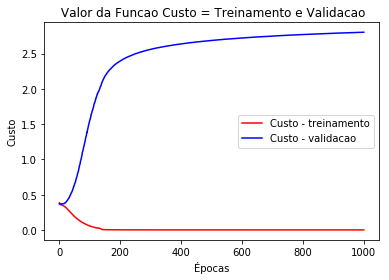

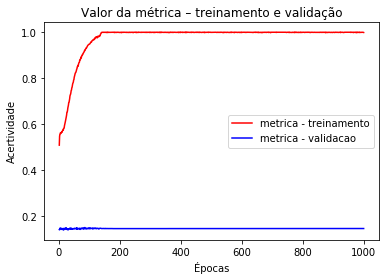

In [35]:
rna4.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna4.plot()

Confusion matrix, without normalization
[[9203 1591]
 [1564 1451]]


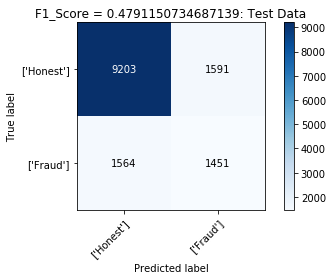

Confusion matrix, without normalization
[[9154 1641]
 [1518 1497]]


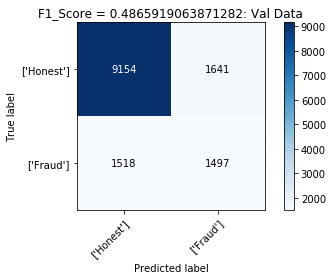

Confusion matrix, without normalization
[[50372     0]
 [    1 14067]]


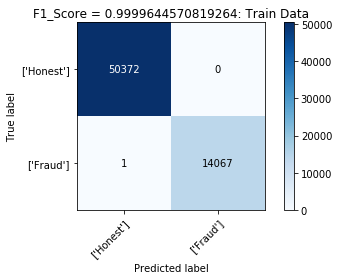

In [36]:
rna4.predict(x_data,y_data)

In [37]:
n_list5 = [100,100,100,1]
activation_list5 = ['tanh','tanh','tanh','sigmoid']

In [38]:
rna5 = new_rna()
rna5.build_model(data_shape,n_list5,activation_list5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 40,401
Trainable params: 40,401
Non-trainable params: 0
_________________________________________________________________


Train on 64440 samples, validate on 13810 samples
Epoch 1/1000
64440/64440 [==============================] - 3s 52us/step - loss: 0.3823 - f1: 0.5034 - val_loss: 0.3703 - val_f1: 0.1420
Epoch 2/1000
64440/64440 [==============================] - 3s 44us/step - loss: 0.3633 - f1: 0.5467 - val_loss: 0.3700 - val_f1: 0.1404
Epoch 3/1000
64440/64440 [==============================] - 3s 44us/step - loss: 0.3614 - f1: 0.5505 - val_loss: 0.3687 - val_f1: 0.1447
Epoch 4/1000
64440/64440 [==============================] - 3s 48us/step - loss: 0.3597 - f1: 0.5556 - val_loss: 0.3680 - val_f1: 0.1447
Epoch 5/1000
64440/64440 [==============================] - 3s 44us/step - loss: 0.3585 - f1: 0.5572 - val_loss: 0.3691 - val_f1: 0.1418
Epoch 6/1000
64440/64440 [==============================] - 3s 44us/step - loss: 0.3572 - f1: 0.5599 - val_loss: 0.3677 - val_f1: 0.1425
Epoch 7/1000
64440/64440 [==============================] - 3s 43us/step - loss: 0.3561 - f1: 0.5622 - val_loss: 0.3688 - val_f1

64440/64440 [==============================] - 3s 43us/step - loss: 0.0075 - f1: 1.0000 - val_loss: 1.5058 - val_f1: 0.1377
Epoch 61/1000
64440/64440 [==============================] - 3s 47us/step - loss: 0.0063 - f1: 0.9995 - val_loss: 1.5310 - val_f1: 0.1389
Epoch 62/1000
64440/64440 [==============================] - 3s 44us/step - loss: 0.0054 - f1: 0.9985 - val_loss: 1.5577 - val_f1: 0.1371
Epoch 63/1000
64440/64440 [==============================] - 3s 44us/step - loss: 0.0048 - f1: 0.9995 - val_loss: 1.5805 - val_f1: 0.1371
Epoch 64/1000
64440/64440 [==============================] - 3s 43us/step - loss: 0.0043 - f1: 1.0000 - val_loss: 1.6006 - val_f1: 0.1388
Epoch 65/1000
64440/64440 [==============================] - 3s 42us/step - loss: 0.0039 - f1: 0.9995 - val_loss: 1.6245 - val_f1: 0.1385
Epoch 66/1000
64440/64440 [==============================] - 3s 39us/step - loss: 0.0036 - f1: 1.0000 - val_loss: 1.6345 - val_f1: 0.1375
Epoch 67/1000
64440/64440 [=====================

64440/64440 [==============================] - 2s 37us/step - loss: 5.0975e-04 - f1: 0.9995 - val_loss: 1.9830 - val_f1: 0.1386
Epoch 119/1000
64440/64440 [==============================] - 3s 41us/step - loss: 4.9994e-04 - f1: 0.9995 - val_loss: 1.9855 - val_f1: 0.1384
Epoch 120/1000
64440/64440 [==============================] - 3s 45us/step - loss: 4.9075e-04 - f1: 0.9980 - val_loss: 1.9889 - val_f1: 0.1384
Epoch 121/1000
64440/64440 [==============================] - 3s 41us/step - loss: 4.8131e-04 - f1: 1.0000 - val_loss: 1.9913 - val_f1: 0.1387
Epoch 122/1000
64440/64440 [==============================] - 3s 42us/step - loss: 4.7240e-04 - f1: 0.9990 - val_loss: 1.9953 - val_f1: 0.1387
Epoch 123/1000
64440/64440 [==============================] - 3s 41us/step - loss: 4.6450e-04 - f1: 0.9995 - val_loss: 1.9976 - val_f1: 0.1389
Epoch 124/1000
64440/64440 [==============================] - 3s 41us/step - loss: 4.5606e-04 - f1: 1.0000 - val_loss: 2.0003 - val_f1: 0.1386
Epoch 125/1000

64440/64440 [==============================] - 3s 42us/step - loss: 2.3048e-04 - f1: 0.9995 - val_loss: 2.0995 - val_f1: 0.1390
Epoch 176/1000
64440/64440 [==============================] - 3s 41us/step - loss: 2.2816e-04 - f1: 1.0000 - val_loss: 2.1012 - val_f1: 0.1386
Epoch 177/1000
64440/64440 [==============================] - 3s 41us/step - loss: 2.2578e-04 - f1: 0.9995 - val_loss: 2.1027 - val_f1: 0.1388
Epoch 178/1000
64440/64440 [==============================] - 3s 43us/step - loss: 2.2345e-04 - f1: 1.0000 - val_loss: 2.1034 - val_f1: 0.1387
Epoch 179/1000
64440/64440 [==============================] - 3s 45us/step - loss: 2.2131e-04 - f1: 1.0000 - val_loss: 2.1058 - val_f1: 0.1386
Epoch 180/1000
64440/64440 [==============================] - 3s 42us/step - loss: 2.1910e-04 - f1: 1.0000 - val_loss: 2.1062 - val_f1: 0.1386
Epoch 181/1000
64440/64440 [==============================] - 3s 41us/step - loss: 2.1694e-04 - f1: 0.9995 - val_loss: 2.1087 - val_f1: 0.1386
Epoch 182/1000

64440/64440 [==============================] - 3s 44us/step - loss: 1.4240e-04 - f1: 1.0000 - val_loss: 2.1640 - val_f1: 0.1388
Epoch 233/1000
64440/64440 [==============================] - 3s 42us/step - loss: 1.4143e-04 - f1: 1.0000 - val_loss: 2.1646 - val_f1: 0.1384
Epoch 234/1000
64440/64440 [==============================] - 3s 42us/step - loss: 1.4044e-04 - f1: 1.0000 - val_loss: 2.1650 - val_f1: 0.1387
Epoch 235/1000
64440/64440 [==============================] - 3s 41us/step - loss: 1.3948e-04 - f1: 1.0000 - val_loss: 2.1661 - val_f1: 0.1387
Epoch 236/1000
64440/64440 [==============================] - 3s 42us/step - loss: 1.3848e-04 - f1: 0.9990 - val_loss: 2.1675 - val_f1: 0.1388
Epoch 237/1000
64440/64440 [==============================] - 3s 42us/step - loss: 1.3760e-04 - f1: 0.9985 - val_loss: 2.1683 - val_f1: 0.1388
Epoch 238/1000
64440/64440 [==============================] - 3s 45us/step - loss: 1.3667e-04 - f1: 0.9990 - val_loss: 2.1692 - val_f1: 0.1386
Epoch 239/1000

64440/64440 [==============================] - 3s 40us/step - loss: 1.0100e-04 - f1: 1.0000 - val_loss: 2.2066 - val_f1: 0.1387
Epoch 290/1000
64440/64440 [==============================] - 3s 40us/step - loss: 1.0048e-04 - f1: 0.9990 - val_loss: 2.2073 - val_f1: 0.1386
Epoch 291/1000
64440/64440 [==============================] - 3s 40us/step - loss: 9.9952e-05 - f1: 1.0000 - val_loss: 2.2080 - val_f1: 0.1386
Epoch 292/1000
64440/64440 [==============================] - 3s 44us/step - loss: 9.9433e-05 - f1: 0.9980 - val_loss: 2.2087 - val_f1: 0.1388
Epoch 293/1000
64440/64440 [==============================] - 3s 40us/step - loss: 9.8931e-05 - f1: 1.0000 - val_loss: 2.2092 - val_f1: 0.1387
Epoch 294/1000
64440/64440 [==============================] - 3s 40us/step - loss: 9.8411e-05 - f1: 0.9990 - val_loss: 2.2099 - val_f1: 0.1385
Epoch 295/1000
64440/64440 [==============================] - 3s 41us/step - loss: 9.7924e-05 - f1: 1.0000 - val_loss: 2.2104 - val_f1: 0.1385
Epoch 296/1000

64440/64440 [==============================] - 3s 41us/step - loss: 7.7349e-05 - f1: 1.0000 - val_loss: 2.2384 - val_f1: 0.1386
Epoch 347/1000
64440/64440 [==============================] - 3s 45us/step - loss: 7.7023e-05 - f1: 0.9980 - val_loss: 2.2392 - val_f1: 0.1386
Epoch 348/1000
64440/64440 [==============================] - 3s 40us/step - loss: 7.6690e-05 - f1: 1.0000 - val_loss: 2.2399 - val_f1: 0.1386
Epoch 349/1000
64440/64440 [==============================] - 3s 41us/step - loss: 7.6369e-05 - f1: 1.0000 - val_loss: 2.2400 - val_f1: 0.1387
Epoch 350/1000
64440/64440 [==============================] - 3s 40us/step - loss: 7.6070e-05 - f1: 1.0000 - val_loss: 2.2405 - val_f1: 0.1386
Epoch 351/1000
64440/64440 [==============================] - 3s 40us/step - loss: 7.5751e-05 - f1: 1.0000 - val_loss: 2.2411 - val_f1: 0.1387
Epoch 352/1000
64440/64440 [==============================] - 3s 41us/step - loss: 7.5432e-05 - f1: 0.9985 - val_loss: 2.2413 - val_f1: 0.1387
Epoch 353/1000

64440/64440 [==============================] - 3s 40us/step - loss: 6.2095e-05 - f1: 1.0000 - val_loss: 2.2640 - val_f1: 0.1388
Epoch 404/1000
64440/64440 [==============================] - 3s 44us/step - loss: 6.1882e-05 - f1: 1.0000 - val_loss: 2.2642 - val_f1: 0.1389
Epoch 405/1000
64440/64440 [==============================] - 3s 40us/step - loss: 6.1660e-05 - f1: 0.9995 - val_loss: 2.2651 - val_f1: 0.1390
Epoch 406/1000
64440/64440 [==============================] - 3s 40us/step - loss: 6.1440e-05 - f1: 0.9995 - val_loss: 2.2651 - val_f1: 0.1389
Epoch 407/1000
64440/64440 [==============================] - 3s 40us/step - loss: 6.1229e-05 - f1: 1.0000 - val_loss: 2.2654 - val_f1: 0.1390
Epoch 408/1000
64440/64440 [==============================] - 3s 40us/step - loss: 6.1012e-05 - f1: 0.9995 - val_loss: 2.2661 - val_f1: 0.1390
Epoch 409/1000
64440/64440 [==============================] - 3s 41us/step - loss: 6.0797e-05 - f1: 0.9995 - val_loss: 2.2660 - val_f1: 0.1390
Epoch 410/1000

64440/64440 [==============================] - 3s 40us/step - loss: 5.1579e-05 - f1: 1.0000 - val_loss: 2.2846 - val_f1: 0.1389
Epoch 461/1000
64440/64440 [==============================] - 3s 40us/step - loss: 5.1424e-05 - f1: 0.9990 - val_loss: 2.2849 - val_f1: 0.1390
Epoch 462/1000
64440/64440 [==============================] - 3s 40us/step - loss: 5.1270e-05 - f1: 0.9995 - val_loss: 2.2852 - val_f1: 0.1390
Epoch 463/1000
64440/64440 [==============================] - 3s 43us/step - loss: 5.1119e-05 - f1: 0.9995 - val_loss: 2.2856 - val_f1: 0.1390
Epoch 464/1000
64440/64440 [==============================] - 3s 42us/step - loss: 5.0967e-05 - f1: 1.0000 - val_loss: 2.2863 - val_f1: 0.1389
Epoch 465/1000
64440/64440 [==============================] - 3s 40us/step - loss: 5.0820e-05 - f1: 1.0000 - val_loss: 2.2864 - val_f1: 0.1389
Epoch 466/1000
64440/64440 [==============================] - 3s 40us/step - loss: 5.0665e-05 - f1: 0.9995 - val_loss: 2.2862 - val_f1: 0.1389
Epoch 467/1000

64440/64440 [==============================] - 3s 42us/step - loss: 4.4035e-05 - f1: 1.0000 - val_loss: 2.3020 - val_f1: 0.1389
Epoch 518/1000
64440/64440 [==============================] - 3s 40us/step - loss: 4.3922e-05 - f1: 1.0000 - val_loss: 2.3025 - val_f1: 0.1389
Epoch 519/1000
64440/64440 [==============================] - 3s 41us/step - loss: 4.3813e-05 - f1: 1.0000 - val_loss: 2.3024 - val_f1: 0.1388
Epoch 520/1000
64440/64440 [==============================] - 3s 40us/step - loss: 4.3703e-05 - f1: 1.0000 - val_loss: 2.3024 - val_f1: 0.1388
Epoch 521/1000
64440/64440 [==============================] - 3s 40us/step - loss: 4.3591e-05 - f1: 0.9995 - val_loss: 2.3026 - val_f1: 0.1388
Epoch 522/1000
64440/64440 [==============================] - 3s 41us/step - loss: 4.3481e-05 - f1: 1.0000 - val_loss: 2.3033 - val_f1: 0.1389
Epoch 523/1000
64440/64440 [==============================] - 3s 41us/step - loss: 4.3369e-05 - f1: 1.0000 - val_loss: 2.3034 - val_f1: 0.1388
Epoch 524/1000

64440/64440 [==============================] - 4s 55us/step - loss: 3.8467e-05 - f1: 1.0000 - val_loss: 2.3160 - val_f1: 0.1388
Epoch 575/1000
64440/64440 [==============================] - 3s 46us/step - loss: 3.8382e-05 - f1: 1.0000 - val_loss: 2.3164 - val_f1: 0.1388
Epoch 576/1000
64440/64440 [==============================] - 3s 49us/step - loss: 3.8297e-05 - f1: 0.9995 - val_loss: 2.3166 - val_f1: 0.1388
Epoch 577/1000
64440/64440 [==============================] - 3s 42us/step - loss: 3.8216e-05 - f1: 0.9991 - val_loss: 2.3166 - val_f1: 0.1388
Epoch 578/1000
64440/64440 [==============================] - 3s 44us/step - loss: 3.8130e-05 - f1: 1.0000 - val_loss: 2.3170 - val_f1: 0.1389
Epoch 579/1000
64440/64440 [==============================] - 3s 46us/step - loss: 3.8050e-05 - f1: 0.9990 - val_loss: 2.3173 - val_f1: 0.1389
Epoch 580/1000
64440/64440 [==============================] - 3s 42us/step - loss: 3.7969e-05 - f1: 1.0000 - val_loss: 2.3173 - val_f1: 0.1389
Epoch 581/1000

64440/64440 [==============================] - 4s 58us/step - loss: 3.4248e-05 - f1: 1.0000 - val_loss: 2.3284 - val_f1: 0.1389
Epoch 632/1000
64440/64440 [==============================] - 3s 53us/step - loss: 3.4182e-05 - f1: 1.0000 - val_loss: 2.3287 - val_f1: 0.1389
Epoch 633/1000
64440/64440 [==============================] - 3s 49us/step - loss: 3.4118e-05 - f1: 0.9995 - val_loss: 2.3288 - val_f1: 0.1390
Epoch 634/1000
64440/64440 [==============================] - 3s 46us/step - loss: 3.4053e-05 - f1: 1.0000 - val_loss: 2.3288 - val_f1: 0.1390
Epoch 635/1000
64440/64440 [==============================] - 3s 44us/step - loss: 3.3990e-05 - f1: 1.0000 - val_loss: 2.3292 - val_f1: 0.1390
Epoch 636/1000
64440/64440 [==============================] - 3s 45us/step - loss: 3.3927e-05 - f1: 1.0000 - val_loss: 2.3295 - val_f1: 0.1390
Epoch 637/1000
64440/64440 [==============================] - 3s 44us/step - loss: 3.3864e-05 - f1: 0.9995 - val_loss: 2.3296 - val_f1: 0.1390
Epoch 638/1000

64440/64440 [==============================] - 3s 46us/step - loss: 3.0963e-05 - f1: 0.9995 - val_loss: 2.3389 - val_f1: 0.1390
Epoch 689/1000
64440/64440 [==============================] - 3s 45us/step - loss: 3.0912e-05 - f1: 0.9995 - val_loss: 2.3388 - val_f1: 0.1390
Epoch 690/1000
64440/64440 [==============================] - 3s 44us/step - loss: 3.0860e-05 - f1: 1.0000 - val_loss: 2.3390 - val_f1: 0.1390
Epoch 691/1000
64440/64440 [==============================] - 3s 44us/step - loss: 3.0809e-05 - f1: 0.9990 - val_loss: 2.3396 - val_f1: 0.1390
Epoch 692/1000
64440/64440 [==============================] - 3s 49us/step - loss: 3.0762e-05 - f1: 0.9995 - val_loss: 2.3392 - val_f1: 0.1390
Epoch 693/1000
64440/64440 [==============================] - 3s 45us/step - loss: 3.0710e-05 - f1: 0.9985 - val_loss: 2.3393 - val_f1: 0.1390
Epoch 694/1000
64440/64440 [==============================] - 3s 45us/step - loss: 3.0660e-05 - f1: 1.0000 - val_loss: 2.3397 - val_f1: 0.1390
Epoch 695/1000

64440/64440 [==============================] - 3s 47us/step - loss: 2.8335e-05 - f1: 0.9995 - val_loss: 2.3477 - val_f1: 0.1391
Epoch 746/1000
64440/64440 [==============================] - 3s 46us/step - loss: 2.8293e-05 - f1: 0.9995 - val_loss: 2.3477 - val_f1: 0.1391
Epoch 747/1000
64440/64440 [==============================] - 3s 45us/step - loss: 2.8251e-05 - f1: 0.9995 - val_loss: 2.3477 - val_f1: 0.1391
Epoch 748/1000
64440/64440 [==============================] - 3s 44us/step - loss: 2.8210e-05 - f1: 1.0000 - val_loss: 2.3479 - val_f1: 0.1391
Epoch 749/1000
64440/64440 [==============================] - 3s 46us/step - loss: 2.8171e-05 - f1: 0.9995 - val_loss: 2.3478 - val_f1: 0.1391
Epoch 750/1000
64440/64440 [==============================] - 3s 44us/step - loss: 2.8128e-05 - f1: 0.9990 - val_loss: 2.3480 - val_f1: 0.1391
Epoch 751/1000
64440/64440 [==============================] - 3s 49us/step - loss: 2.8086e-05 - f1: 0.9995 - val_loss: 2.3484 - val_f1: 0.1391
Epoch 752/1000

64440/64440 [==============================] - 3s 44us/step - loss: 2.6162e-05 - f1: 1.0000 - val_loss: 2.3555 - val_f1: 0.1391
Epoch 803/1000
64440/64440 [==============================] - 3s 45us/step - loss: 2.6127e-05 - f1: 1.0000 - val_loss: 2.3553 - val_f1: 0.1391
Epoch 804/1000
64440/64440 [==============================] - 3s 46us/step - loss: 2.6092e-05 - f1: 1.0000 - val_loss: 2.3556 - val_f1: 0.1391
Epoch 805/1000
64440/64440 [==============================] - 3s 47us/step - loss: 2.6057e-05 - f1: 0.9995 - val_loss: 2.3558 - val_f1: 0.1391
Epoch 806/1000
64440/64440 [==============================] - 3s 45us/step - loss: 2.6024e-05 - f1: 1.0000 - val_loss: 2.3558 - val_f1: 0.1391
Epoch 807/1000
64440/64440 [==============================] - 3s 45us/step - loss: 2.5988e-05 - f1: 0.9995 - val_loss: 2.3562 - val_f1: 0.1391
Epoch 808/1000
64440/64440 [==============================] - 3s 45us/step - loss: 2.5954e-05 - f1: 0.9995 - val_loss: 2.3562 - val_f1: 0.1391
Epoch 809/1000

64440/64440 [==============================] - 3s 50us/step - loss: 2.4326e-05 - f1: 0.9990 - val_loss: 2.3625 - val_f1: 0.1390
Epoch 860/1000
64440/64440 [==============================] - 3s 44us/step - loss: 2.4297e-05 - f1: 0.9990 - val_loss: 2.3628 - val_f1: 0.1391
Epoch 861/1000
64440/64440 [==============================] - 3s 44us/step - loss: 2.4267e-05 - f1: 0.9995 - val_loss: 2.3630 - val_f1: 0.1391
Epoch 862/1000
64440/64440 [==============================] - 3s 45us/step - loss: 2.4238e-05 - f1: 1.0000 - val_loss: 2.3632 - val_f1: 0.1390
Epoch 863/1000
64440/64440 [==============================] - 3s 45us/step - loss: 2.4208e-05 - f1: 1.0000 - val_loss: 2.3635 - val_f1: 0.1391
Epoch 864/1000
64440/64440 [==============================] - 3s 45us/step - loss: 2.4178e-05 - f1: 0.9995 - val_loss: 2.3630 - val_f1: 0.1391
Epoch 865/1000
64440/64440 [==============================] - 3s 49us/step - loss: 2.4149e-05 - f1: 1.0000 - val_loss: 2.3633 - val_f1: 0.1391
Epoch 866/1000

64440/64440 [==============================] - 3s 44us/step - loss: 2.2748e-05 - f1: 0.9980 - val_loss: 2.3690 - val_f1: 0.1392
Epoch 917/1000
64440/64440 [==============================] - 3s 46us/step - loss: 2.2722e-05 - f1: 1.0000 - val_loss: 2.3693 - val_f1: 0.1392
Epoch 918/1000
64440/64440 [==============================] - 3s 47us/step - loss: 2.2697e-05 - f1: 1.0000 - val_loss: 2.3694 - val_f1: 0.1392
Epoch 919/1000
64440/64440 [==============================] - 3s 46us/step - loss: 2.2671e-05 - f1: 0.9995 - val_loss: 2.3692 - val_f1: 0.1392
Epoch 920/1000
64440/64440 [==============================] - 3s 45us/step - loss: 2.2646e-05 - f1: 0.9995 - val_loss: 2.3694 - val_f1: 0.1392
Epoch 921/1000
64440/64440 [==============================] - 3s 44us/step - loss: 2.2621e-05 - f1: 1.0000 - val_loss: 2.3693 - val_f1: 0.1392
Epoch 922/1000
64440/64440 [==============================] - 3s 45us/step - loss: 2.2595e-05 - f1: 0.9990 - val_loss: 2.3698 - val_f1: 0.1392
Epoch 923/1000

64440/64440 [==============================] - 3s 50us/step - loss: 2.1373e-05 - f1: 1.0000 - val_loss: 2.3750 - val_f1: 0.1392
Epoch 974/1000
64440/64440 [==============================] - 3s 48us/step - loss: 2.1352e-05 - f1: 1.0000 - val_loss: 2.3751 - val_f1: 0.1392
Epoch 975/1000
64440/64440 [==============================] - 3s 44us/step - loss: 2.1330e-05 - f1: 1.0000 - val_loss: 2.3748 - val_f1: 0.1392
Epoch 976/1000
64440/64440 [==============================] - 3s 44us/step - loss: 2.1307e-05 - f1: 1.0000 - val_loss: 2.3754 - val_f1: 0.1392
Epoch 977/1000
64440/64440 [==============================] - 3s 45us/step - loss: 2.1285e-05 - f1: 0.9995 - val_loss: 2.3756 - val_f1: 0.1392
Epoch 978/1000
64440/64440 [==============================] - 3s 49us/step - loss: 2.1262e-05 - f1: 0.9995 - val_loss: 2.3755 - val_f1: 0.1392
Epoch 979/1000
64440/64440 [==============================] - 3s 45us/step - loss: 2.1240e-05 - f1: 1.0000 - val_loss: 2.3751 - val_f1: 0.1392
Epoch 980/1000

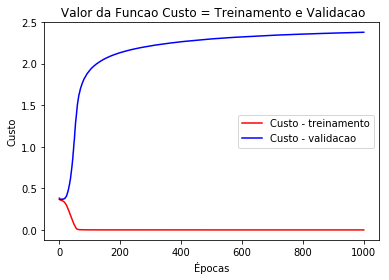

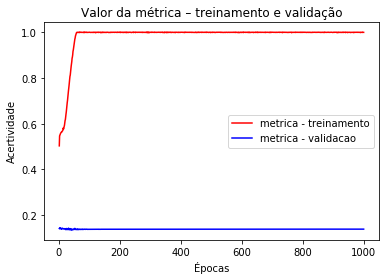

In [39]:
rna5.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna5.plot()

Confusion matrix, without normalization
[[9301 1493]
 [1535 1480]]


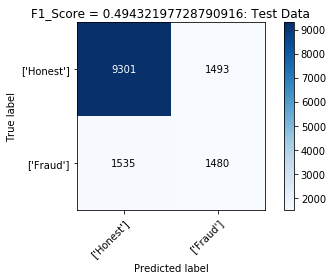

Confusion matrix, without normalization
[[9315 1480]
 [1593 1422]]


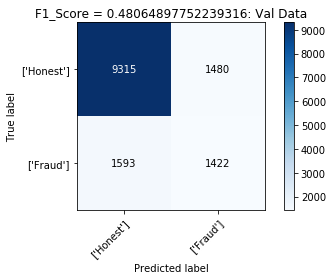

Confusion matrix, without normalization
[[50372     0]
 [    0 14068]]


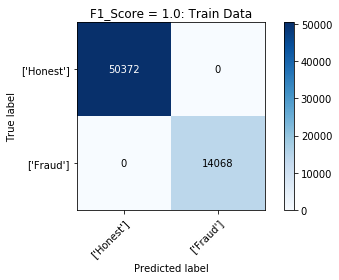

In [40]:
rna5.predict(x_data,y_data)